In [2]:
!pip install pyreadr
!pip install anndata
!pip install squidpy
!pip install Seaborn
!pip install scanpy

import pyreadr
import pandas as pd
import scanpy as sc
from anndata import AnnData
import squidpy as sq
import seaborn as sns
import numpy as np
import matplotlib

from sklearn.cluster import KMeans
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

  Using cached botocore-1.29.76-py3-none-any.whl (10.4 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.29.76
    Uninstalling botocore-1.29.76:
      Successfully uninstalled botocore-1.29.76
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.28.50 requires botocore<1.32.0,>=1.31.50, but you have botocore 1.29.76 which is incompatible.


In [3]:
healthyResFiles = [pd.read_csv("/Users/khoahuynh/Downloads/Whole slide segmentation/Spatial_annotation/S2P1_neighbor.csv"),
        pd.read_csv("/Users/khoahuynh/Downloads/Whole slide segmentation/Spatial_annotation/S4P1_neighbor.csv"),
        pd.read_csv("/Users/khoahuynh/Downloads/Whole slide segmentation/Spatial_annotation/S4P2_neighbor.csv"),
        pd.read_csv("/Users/khoahuynh/Downloads/Whole slide segmentation/Spatial_annotation/S5P1_neighbor.csv"),
        pd.read_csv("/Users/khoahuynh/Downloads/Whole slide segmentation/Spatial_annotation/S5P2_neighbor.csv"),
        pd.read_csv("/Users/khoahuynh/Downloads/Whole slide segmentation/Spatial_annotation/S6P1_neighbor.csv"),
        pd.read_csv("/Users/khoahuynh/Downloads/Whole slide segmentation/Spatial_annotation/S6P1b_neighbor.csv")
                  ]

diseaseResFiles = [pd.read_csv("/Users/khoahuynh/Downloads/Whole slide segmentation/Spatial_annotation/S1P1_neighbor.csv"),
        pd.read_csv("/Users/khoahuynh/Downloads/Whole slide segmentation/Spatial_annotation/S3P1_neighbor.csv"),
        pd.read_csv("/Users/khoahuynh/Downloads/Whole slide segmentation/Spatial_annotation/S3P2_neighbor.csv")
                  ]

In [4]:
import copy

def preprocessRes(resDf):
  #isolate spatial coordinates
  coordDf = resDf[["X", "Y"]]
  coords = coordDf.to_numpy()

  #isolate marker mean value columns
  threshDf = resDf[["EPCAM",  "Keratin8_18", "PanCK"     ,  "Collagen_IV", "Keratin14"  , "SMA"     ,    "VIM"      ,   "CD31"     ,   "CD34"  ,     
           "Podoplanin" , "CD45"   ,     "HLA_DR"  ,    "CD11c"    ,   "MPO"   ,      "CD141"   ,    "CD56"    ,    "CD3e"   ,     "FOXP3"  ,    
           "CD4"    ,     "CD8"     ,    "CD20"     ,   "HHP3"    ,    "GATA3"    ,   "GZMB"     ,   "Ki67"    ,    "Galectin3"  , "HLA_A"  ,    
           "CD45RO"  ,    "CD21"    ,    "PD_L1"   ,    "PD1"     ,    "IDO1"     ,   "CD107a"    ,  "ICOS"    ,    "Bcl_2"    ,   "CD66"  ,     
           "IFNG"]] #CD14 removed

  #isolate cell type annotations
  tacitPredDf = resDf[["predicted"]]

  return resDf, coords, threshDf, tacitPredDf

def addTacitPred(ad, predDf):
  ad.obs["predicted"] = predDf.values.flatten() #check this just in case... unsure why needed to flatten
  ad.obs['predicted'] = ad.obs['predicted'].astype('category')

def getCellTypes(ad):
  """get ordered list of cell types; same order as presented in interaction matrix"""
  return ad.obs["predicted"].cat.categories.to_list()

def removeOtherCat(ad):
  cellTypesLst = getCellTypes(ad)
  otherInd = cellTypesLst.index('Others')

  #make a copy of intmat and remove the row and coloumn of 'Others'
  intMat = copy.deepcopy(ad.uns['predicted_interactions'])
  intMat = np.delete(intMat, otherInd, axis=0)
  intMat = np.delete(intMat, otherInd, axis=1)

  cellTypesLst.remove('Others')

  #create dataframe
  intMatDf = pd.DataFrame(intMat)
  intMatDf.columns = cellTypesLst
  intMatDf.index = cellTypesLst

  #drop any rows/cols full of 0s
  intMatDf = intMatDf.loc[(intMatDf != 0).any(axis=1)]
  intMatDf = intMatDf.loc[:, (intMatDf != 0).any(axis=0)]

  return intMatDf, intMatDf.columns

def sumMatsByCat(mat1, mat2):
  #Get all unique row and column labels from both DataFrames
  rows = np.union1d(mat1.index, mat2.index)
  cols = np.union1d(mat1.columns, mat2.columns)

  #Initialize the final matrix with zeros
  finalMatrix = pd.DataFrame(0, index=rows, columns=cols)

  #Add corresponding elements from the mat1
  finalMatrix.loc[mat1.index, mat1.columns] += mat1.values

  #Add corresponding elements from the mat2
  finalMatrix.loc[mat2.index, mat2.columns] += mat2.values
  return finalMatrix

def subtractionMatrix(mat1, mat2):
  #Get all unique row and column labels from both DataFrames
  rows = np.union1d(mat1.index, mat2.index)
  cols = np.union1d(mat1.columns, mat2.columns)

  #Initialize the final matrix with zeros
  finalMatrix = pd.DataFrame(0, index=rows, columns=cols)

  #Add corresponding elements from the mat1
  finalMatrix.loc[mat1.index, mat1.columns] += mat1.values

  #subtract corresponding elements from the mat2
  finalMatrix.loc[mat2.index, mat2.columns] -= mat2.values
  return finalMatrix

def combineIntMats(finalMat, subMats):
  for roi, mat in subMats.items():
    if roi in finalMat:
      finalMat[roi] = sumMatsByCat(finalMat[roi], copy.deepcopy(mat))
    else:
      finalMat[roi] = copy.deepcopy(mat)

  return finalMat


/Users/khoahuynh/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/khoahuynh/anaconda3/lib/python3.11/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/Users/khoahuynh/anaconda3/lib/python3.11/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/Users/khoahuynh/anaconda3/lib/python3.11/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dt

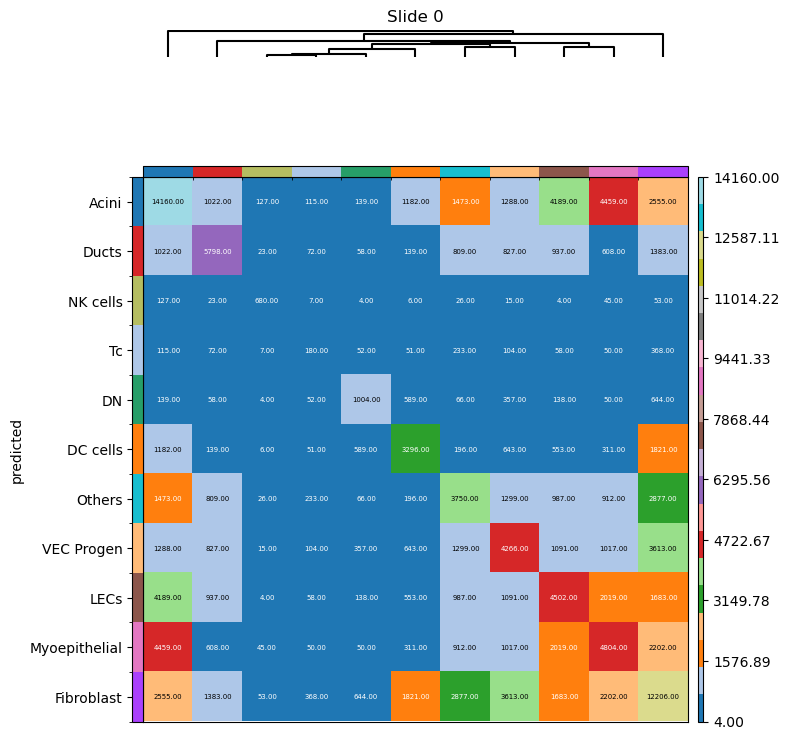

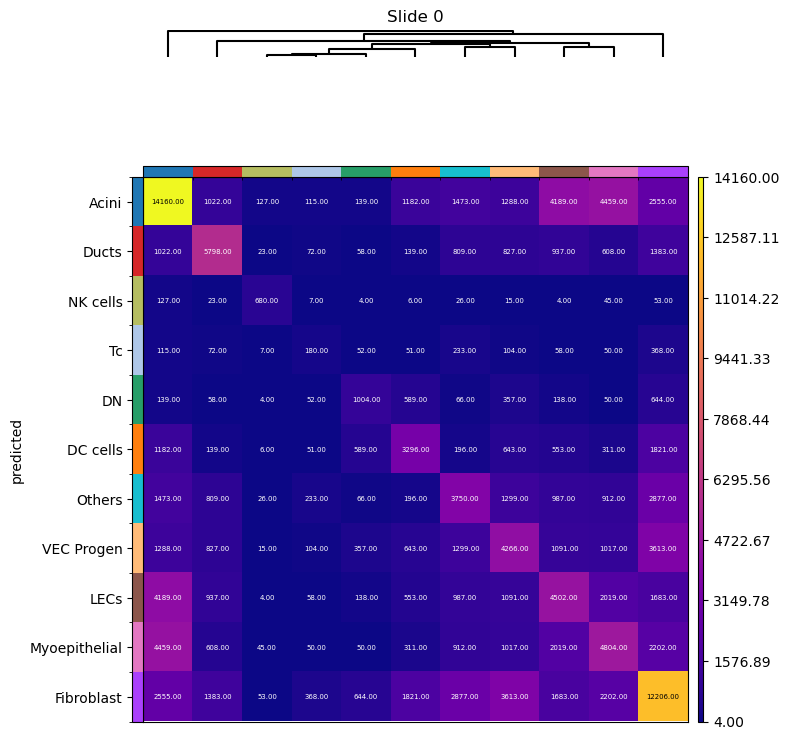

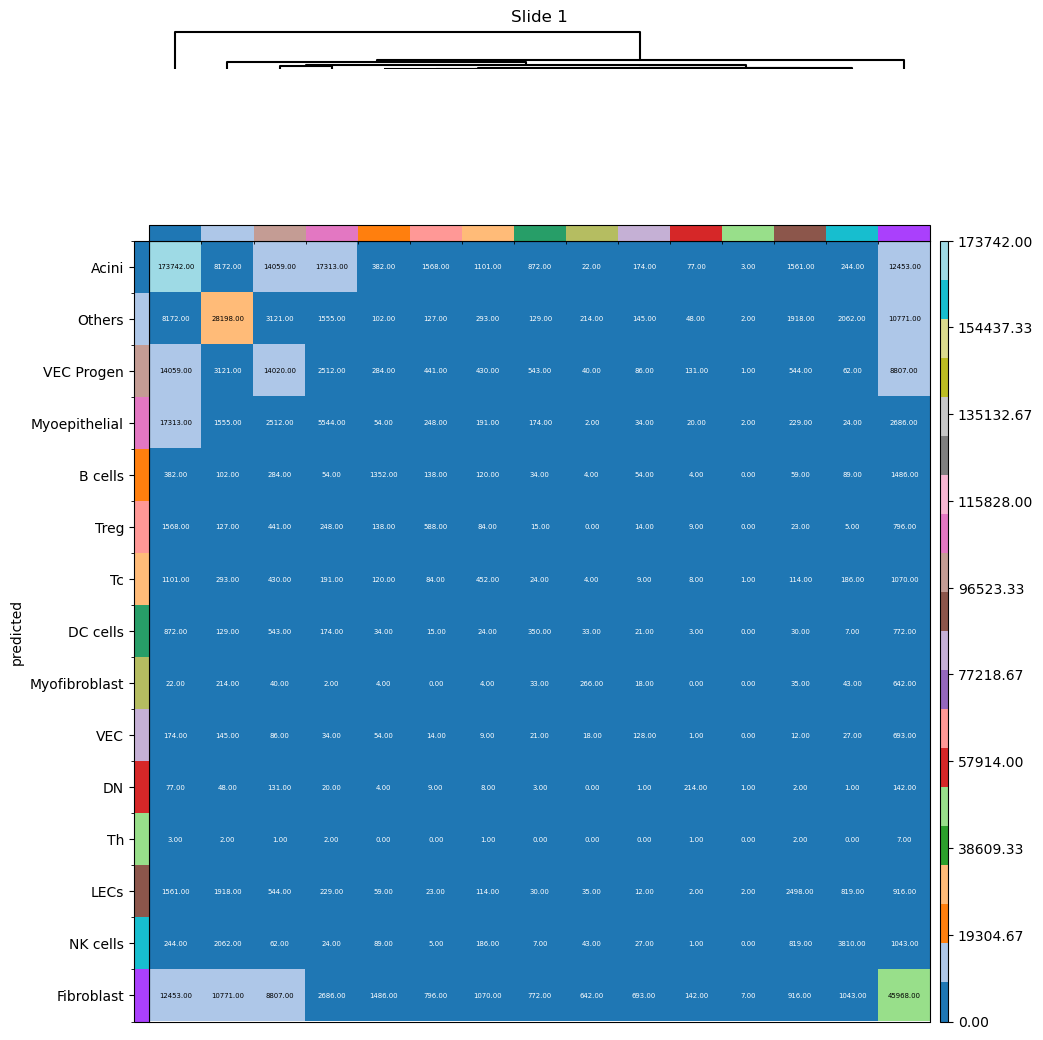

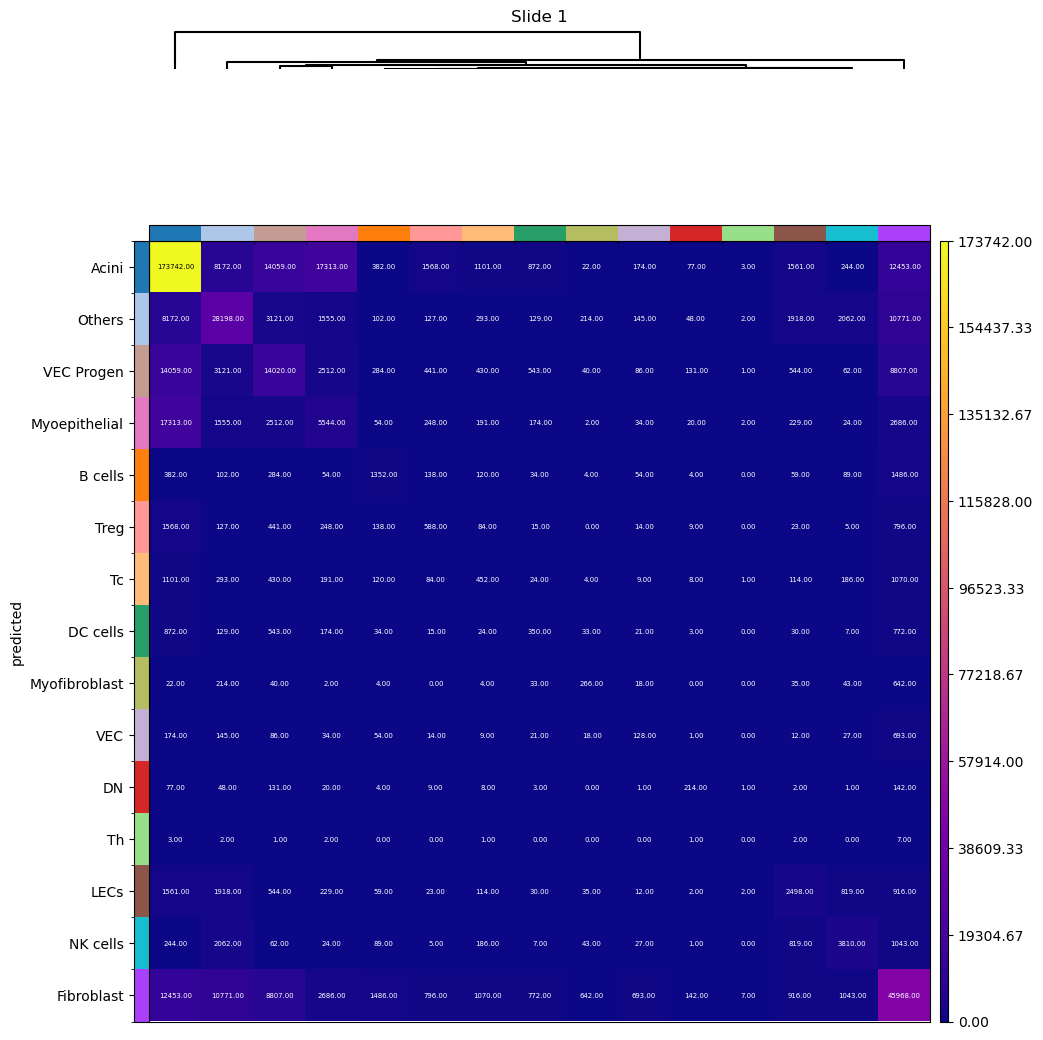

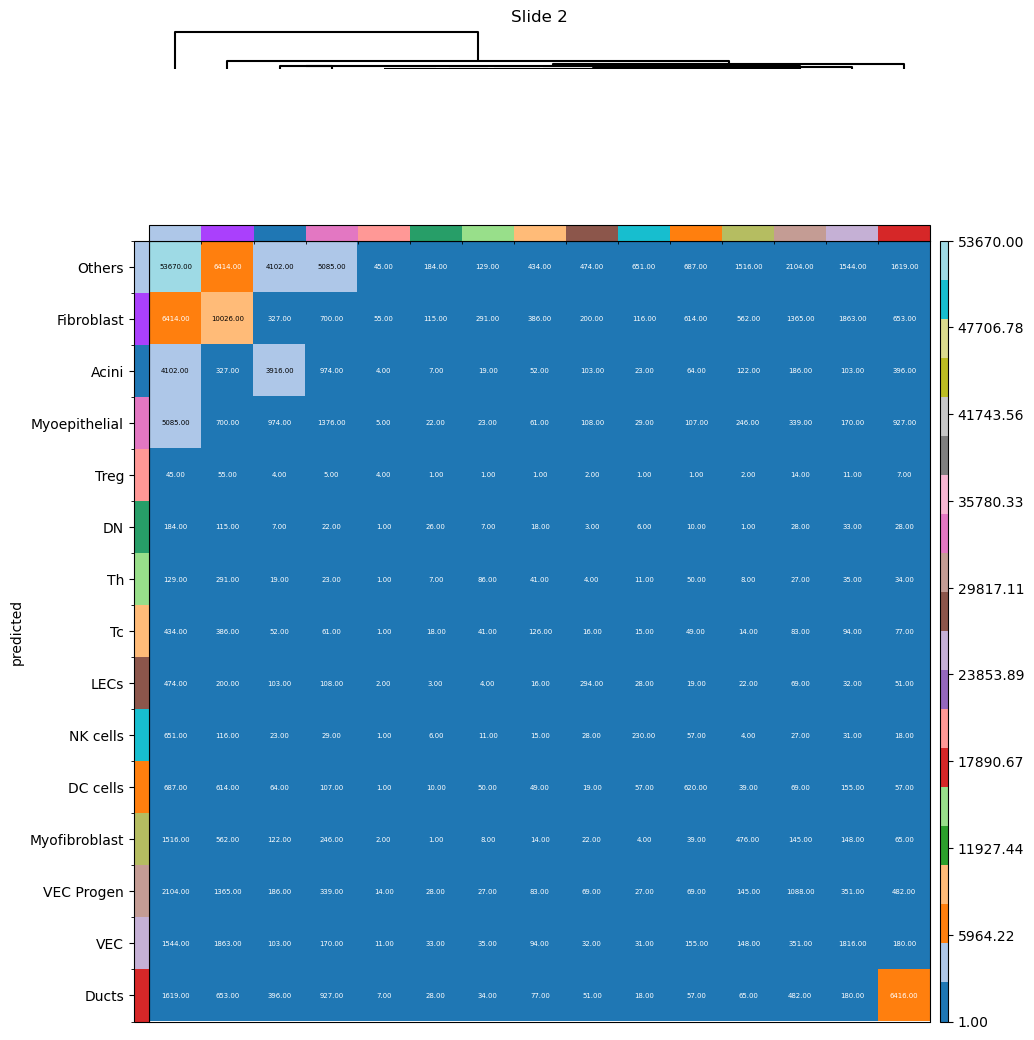

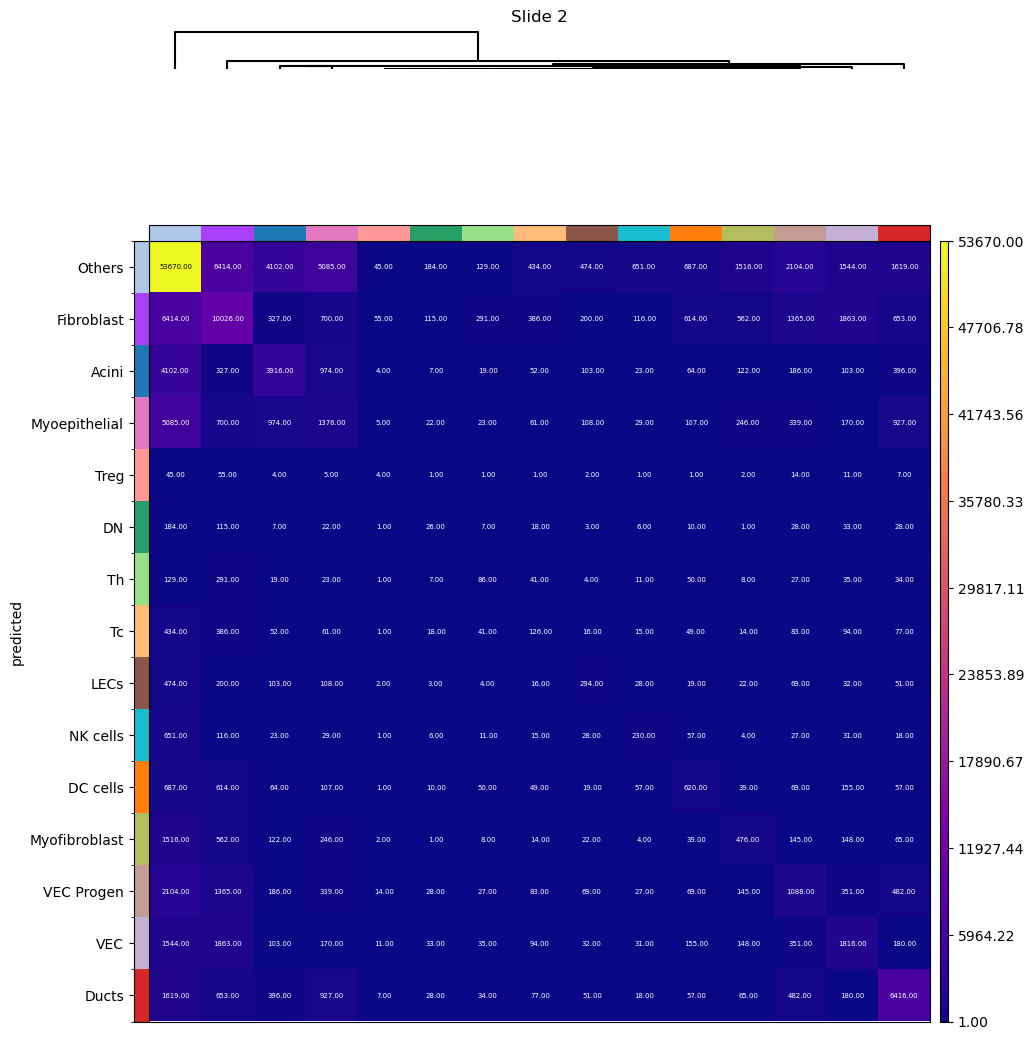

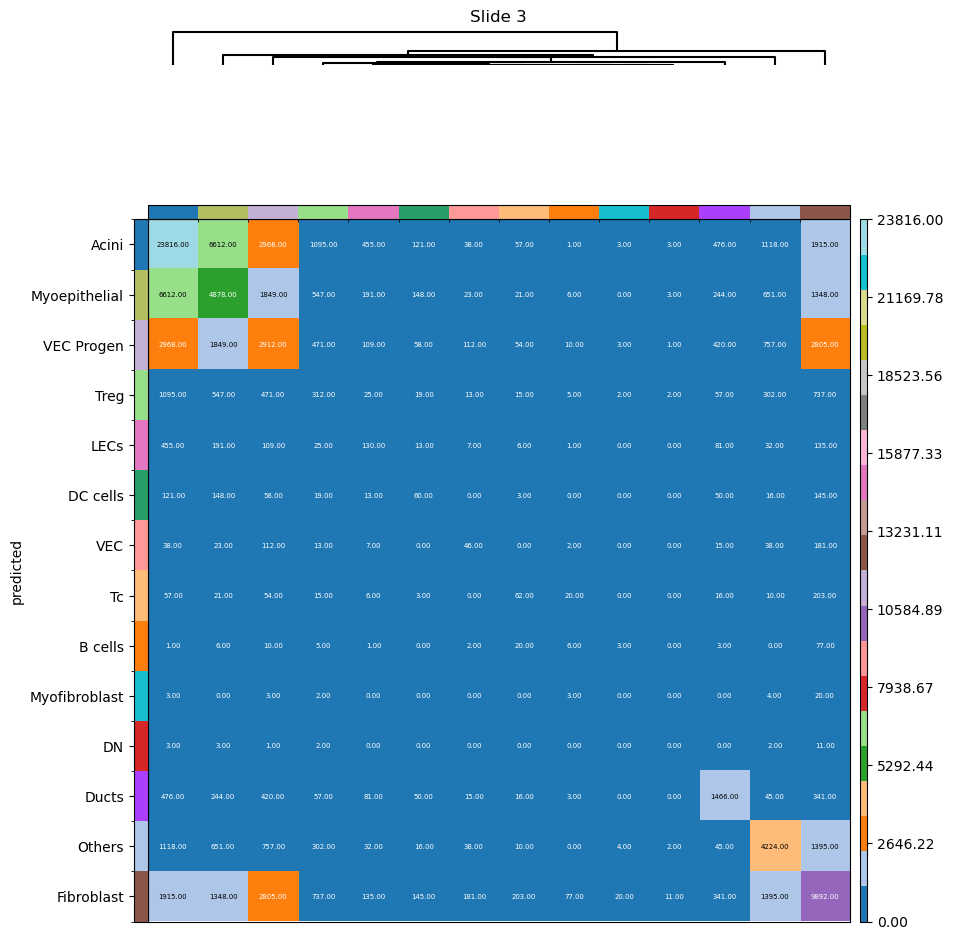

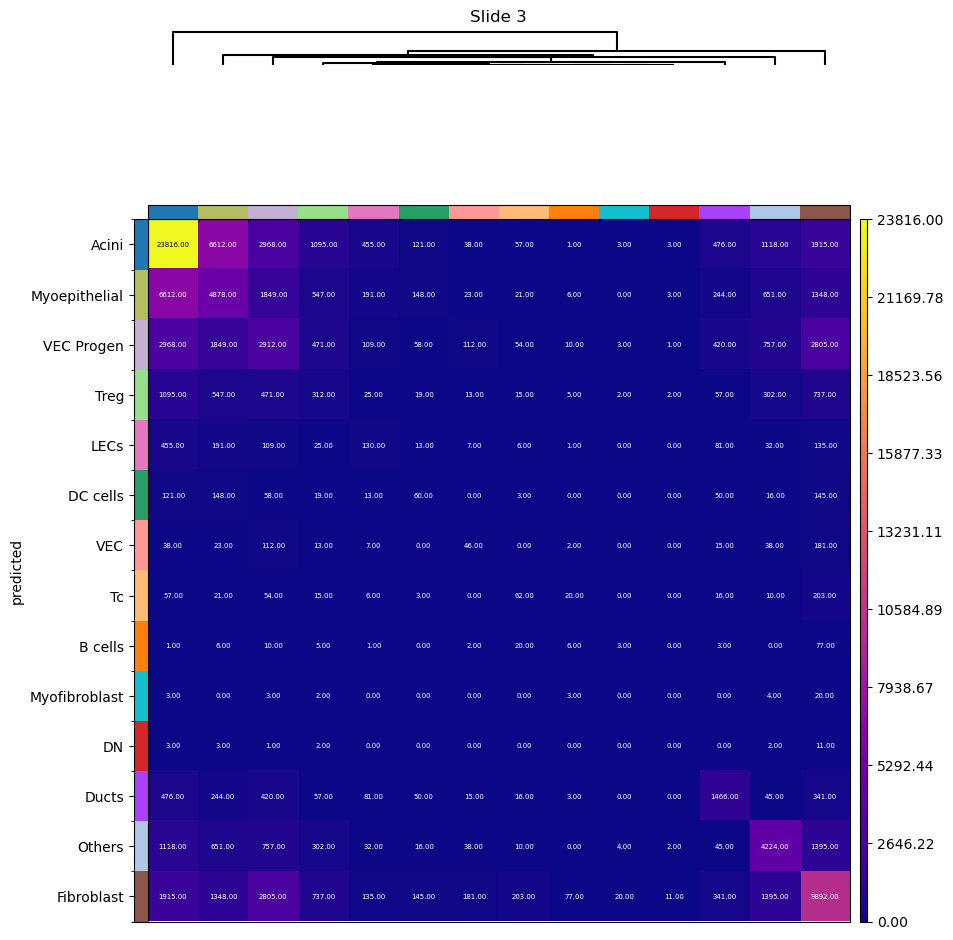

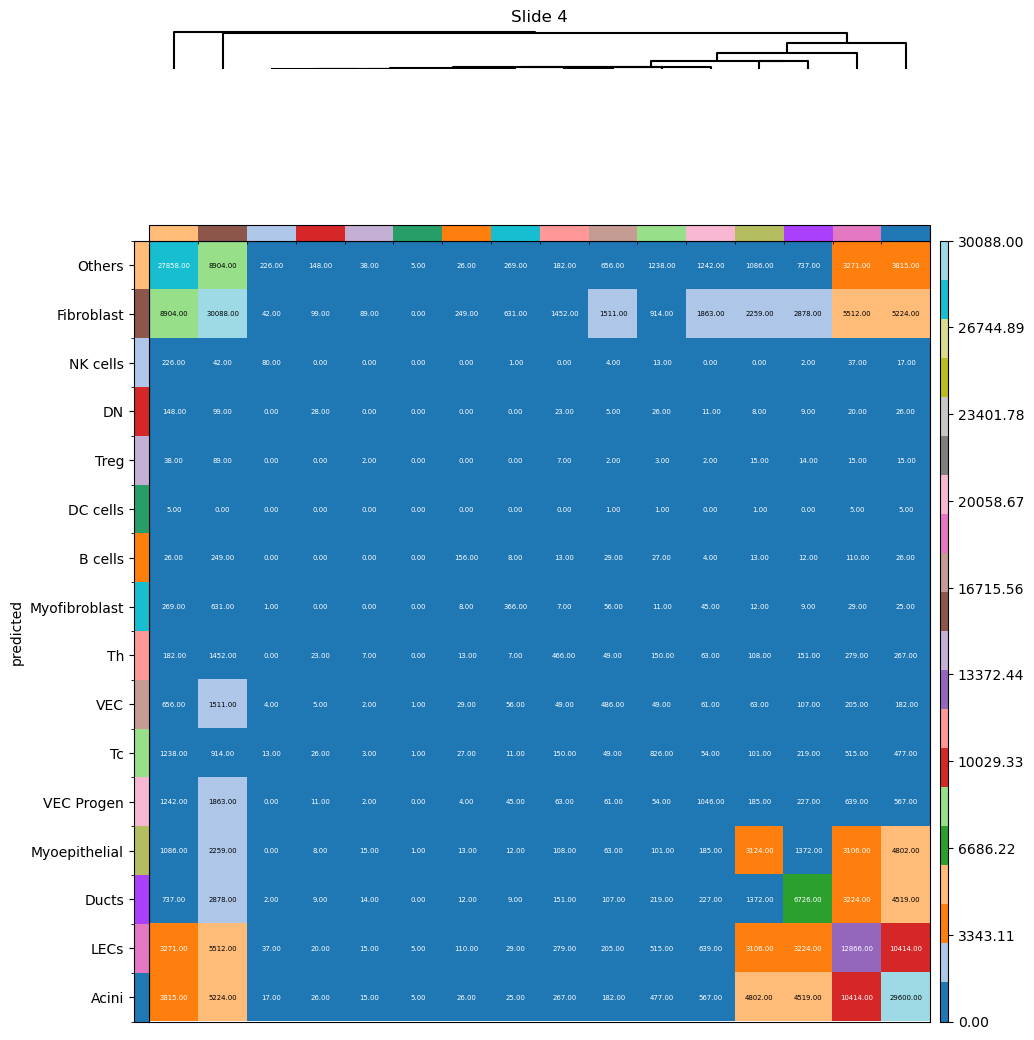

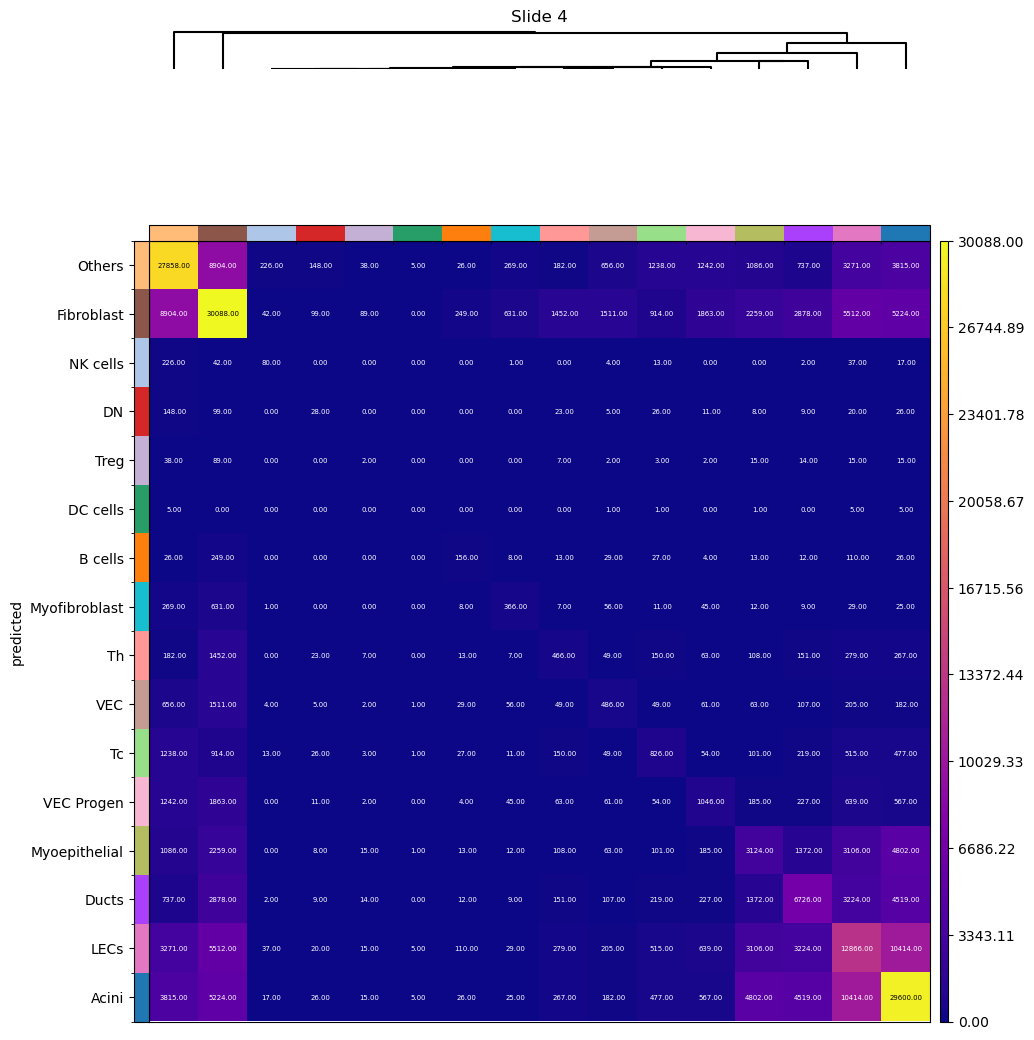

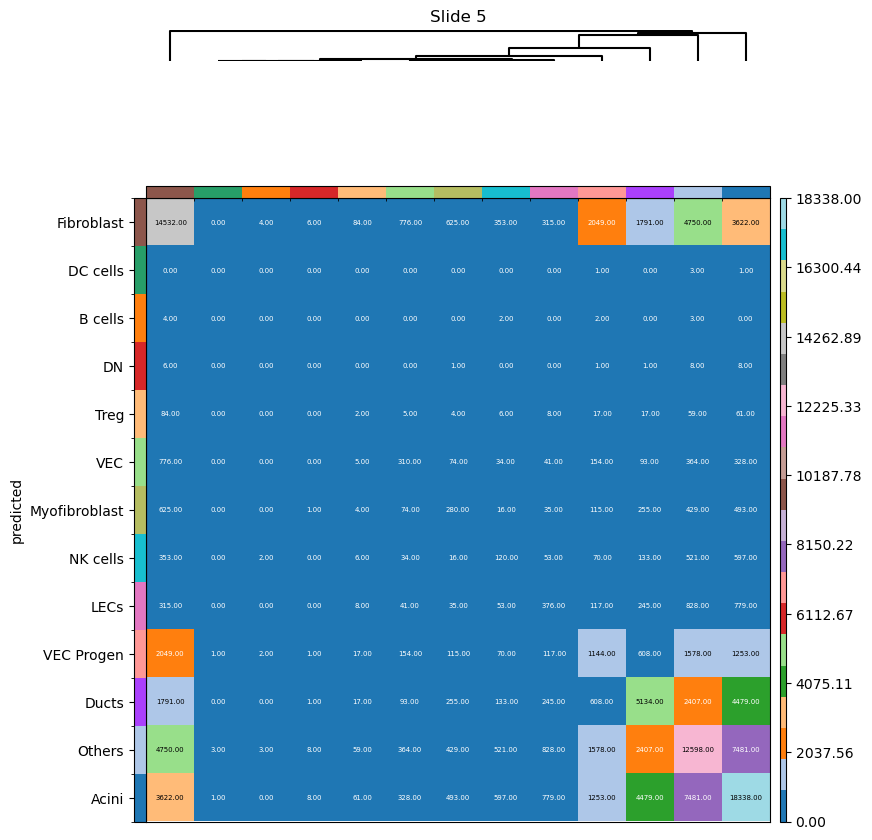

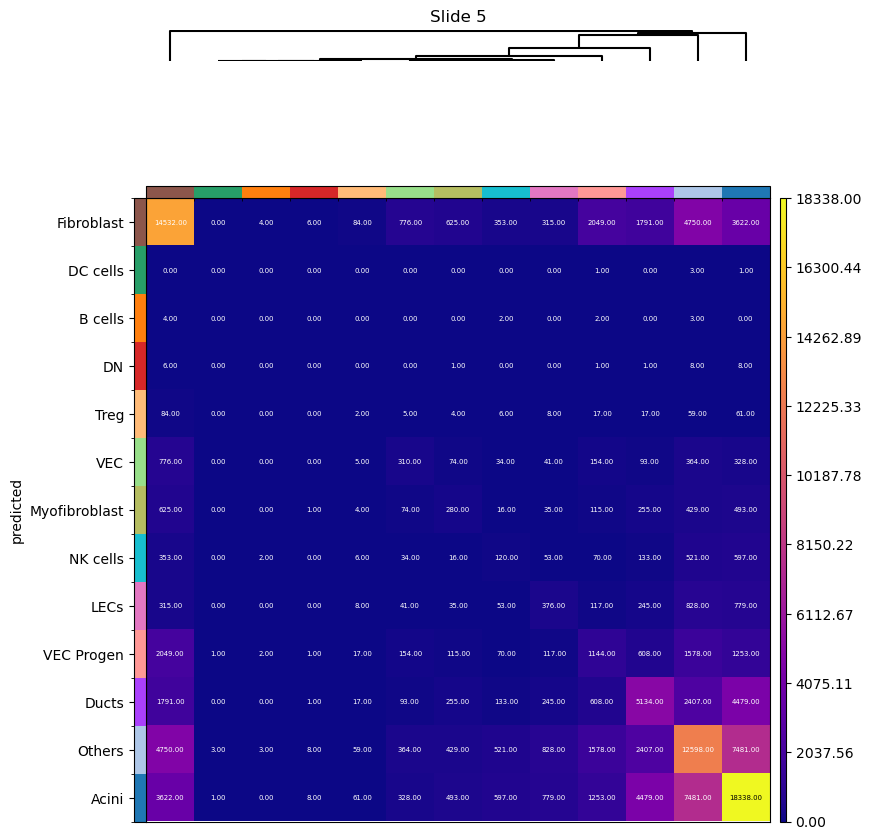

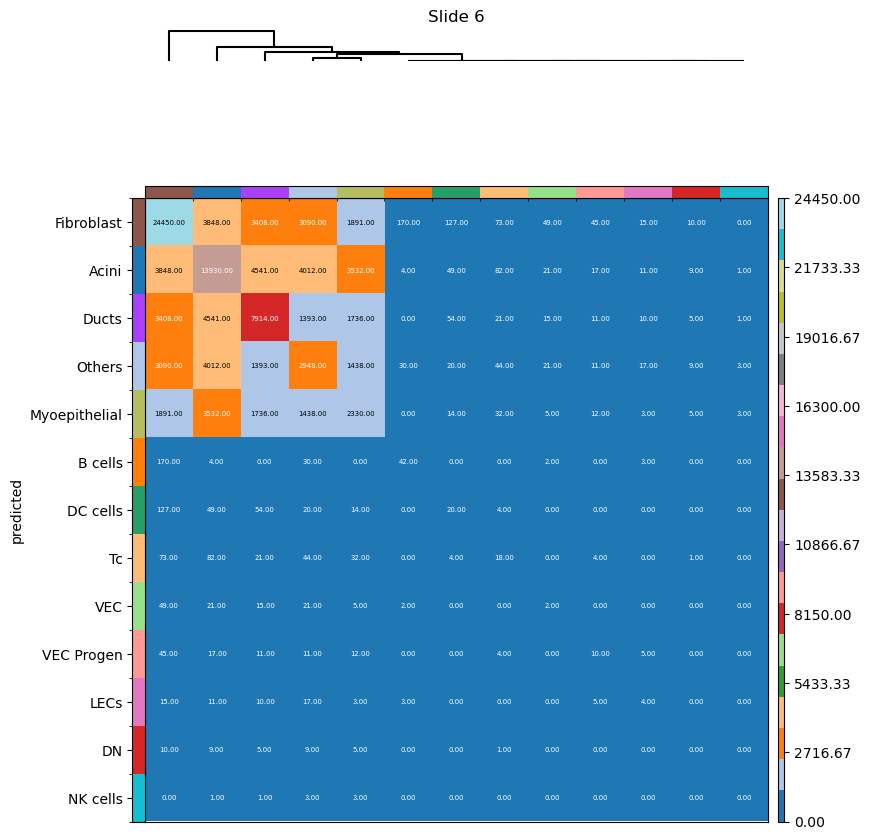

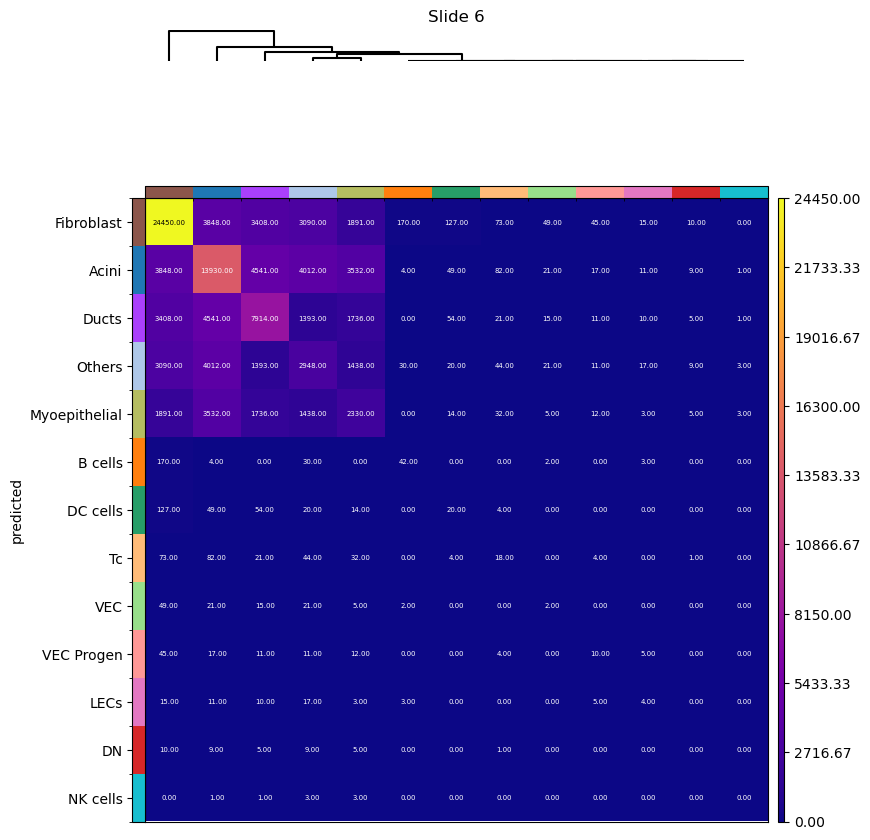

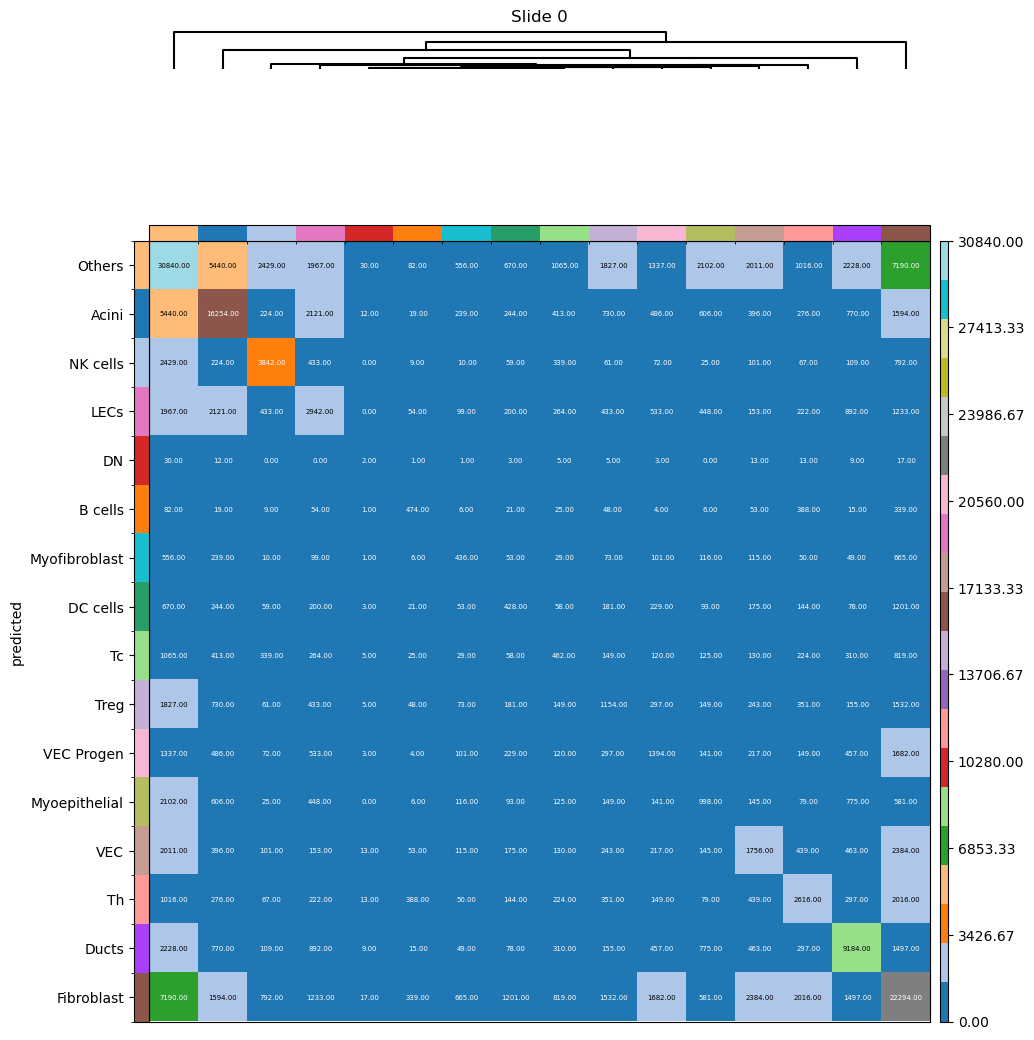

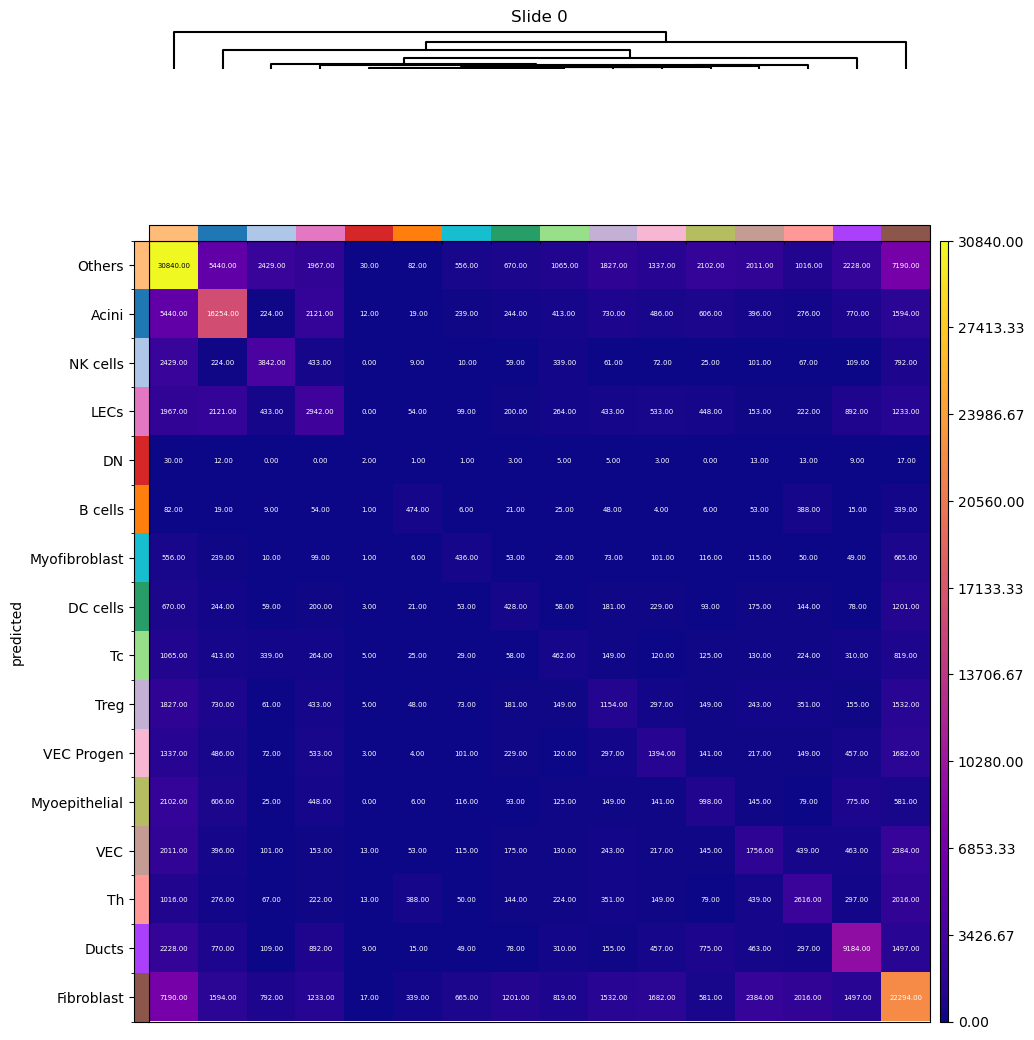

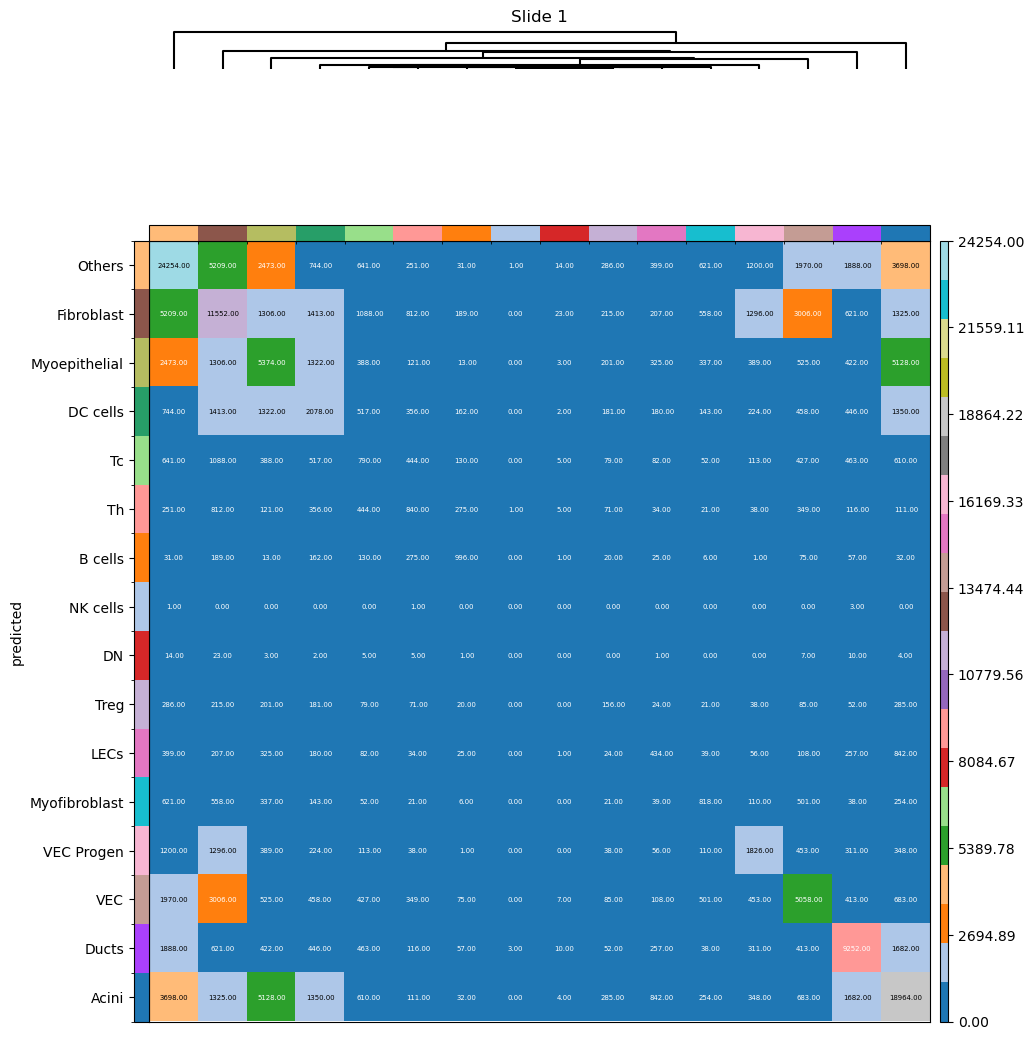

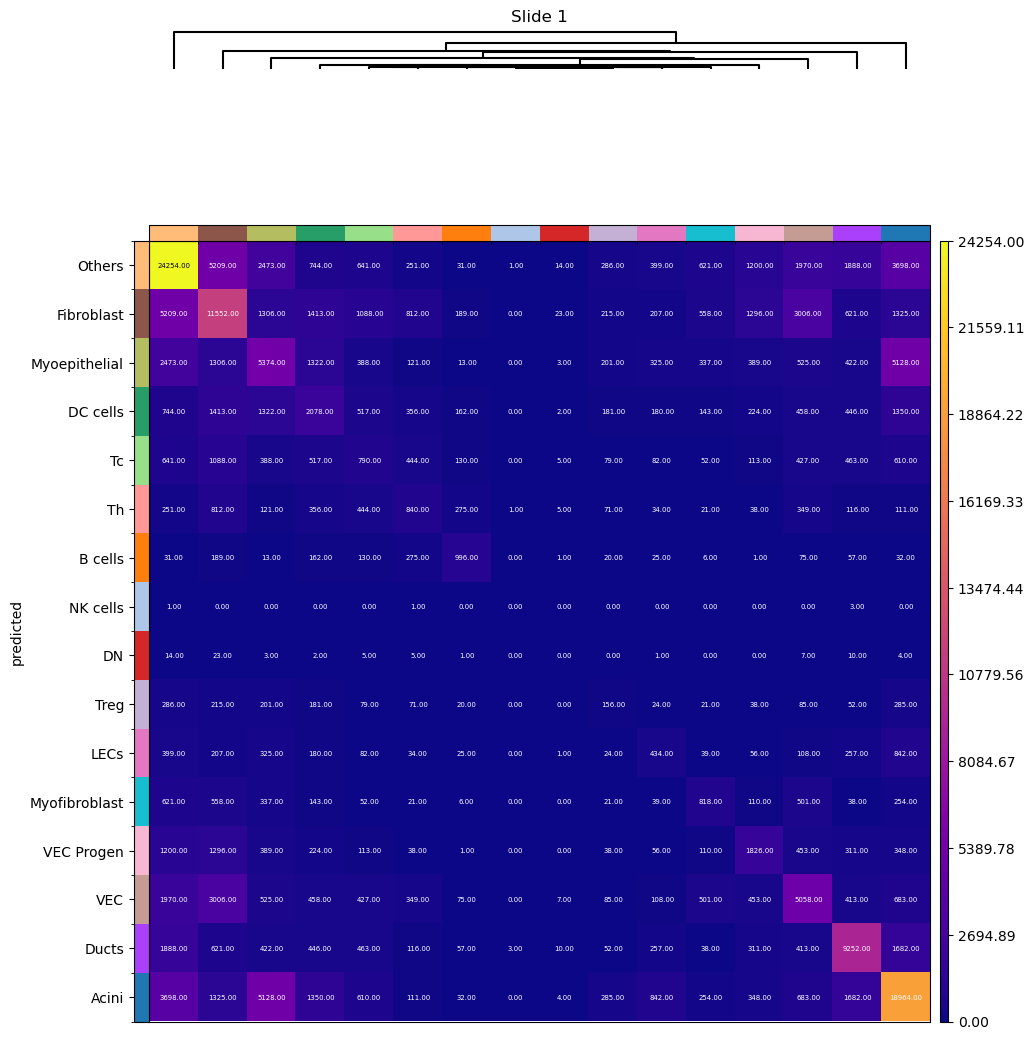

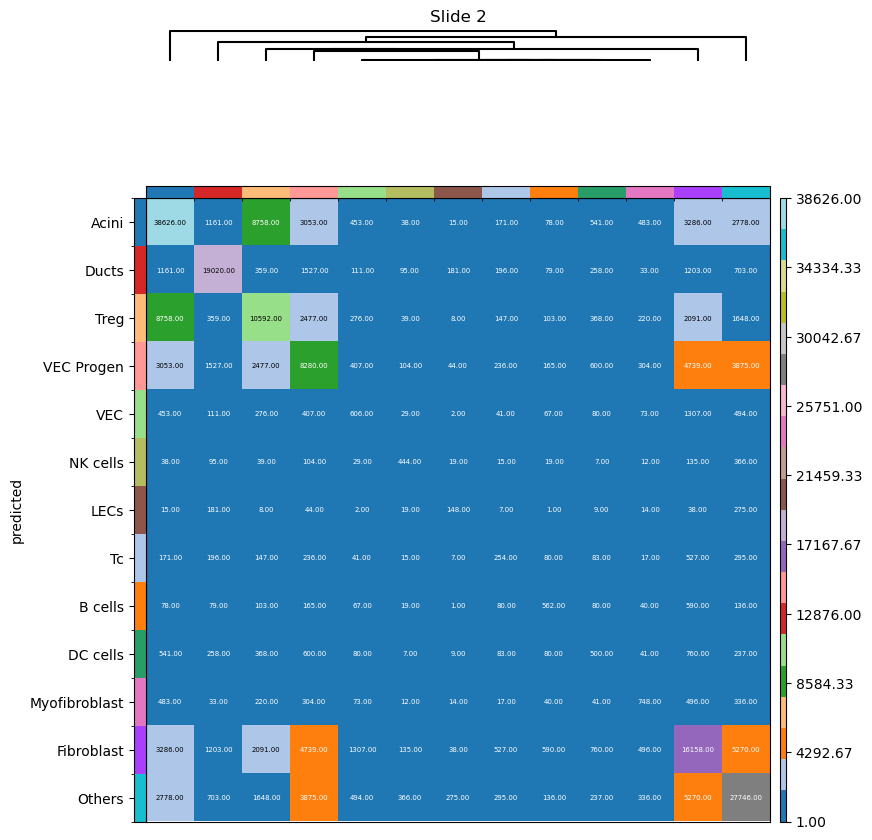

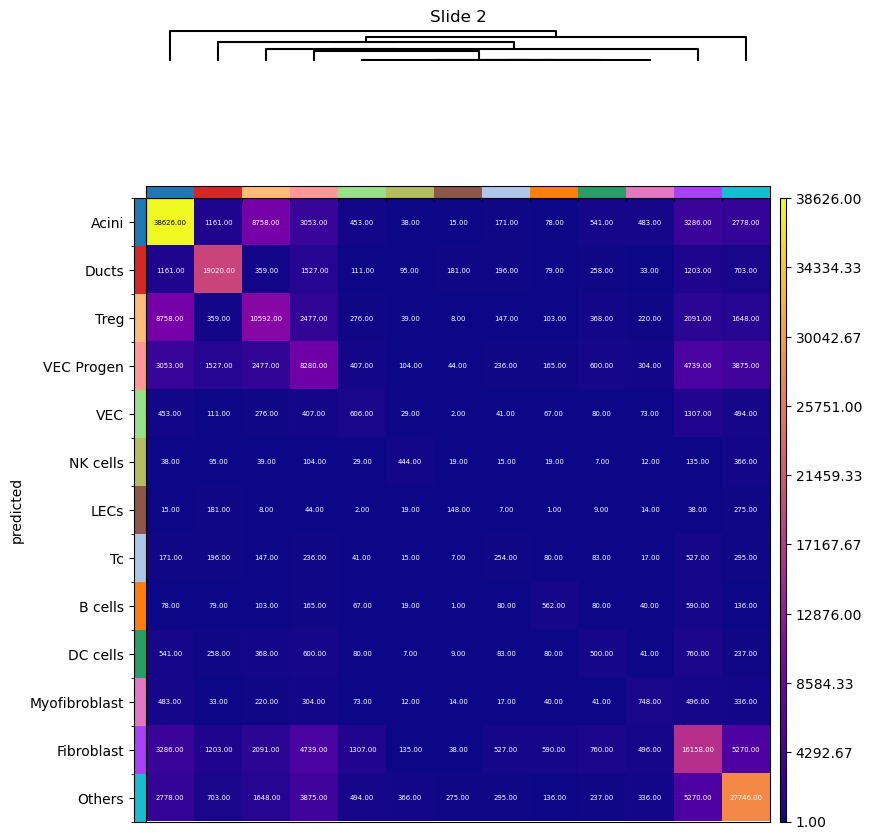

In [5]:
ads = dict()
ads["healthy"] = []
ads["disease"] = []

for cat in ["healthy", "disease"]:

  if cat == "healthy":
    resFiles = healthyResFiles
  else:
    resFiles = diseaseResFiles

  for i in range(len(resFiles)):
    resDf = resFiles[i]

    #extract infro from resfiles
    resDf, coords, threshDf, tacitPredDf = preprocessRes(resDf)

    #add them to the adata
    adata = AnnData(X = threshDf, obsm={"spatial": coords})
    addTacitPred(adata, tacitPredDf)

    #create neighborhood graph
    sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay = True, percentile=97.0)
    #sc.pl.spatial(adata, color="predict_TACIT", neighbors_key = "spatial_neighbors", spot_size=10, edges=True, edges_color='black', title="Foci " + str(i))

    #make interaction matrix
    sq.gr.interaction_matrix(adata, cluster_key="predicted")
    sq.pl.interaction_matrix(adata, cluster_key="predicted", annotate=True, method="single", title="Slide " + str(i), cmap='tab20', size=5, save ="./" + str(i) +"_tab20.png")
    sq.pl.interaction_matrix(adata, cluster_key="predicted", annotate=True, method="single", title="Slide " + str(i), cmap='plasma', size=5, save ="./" + str(i) +"_plasma.png")
    
    ads[cat].append(adata)



        predicted
0          Others
1      Fibroblast
2           Acini
3              Th
4          Others
...           ...
38875         VEC
38876  Fibroblast
38877       Acini
38878  Fibroblast
38879      Others

[38880 rows x 1 columns]


/Users/khoahuynh/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


(1.0, 0.8352941176470589, 0.0, 1.0)


/Users/khoahuynh/anaconda3/lib/python3.11/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/Users/khoahuynh/anaconda3/lib/python3.11/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/Users/khoahuynh/anaconda3/lib/python3.11/site-packages/squidpy/pl/_utils.py:556: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]
/Users/khoahuynh/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_cate

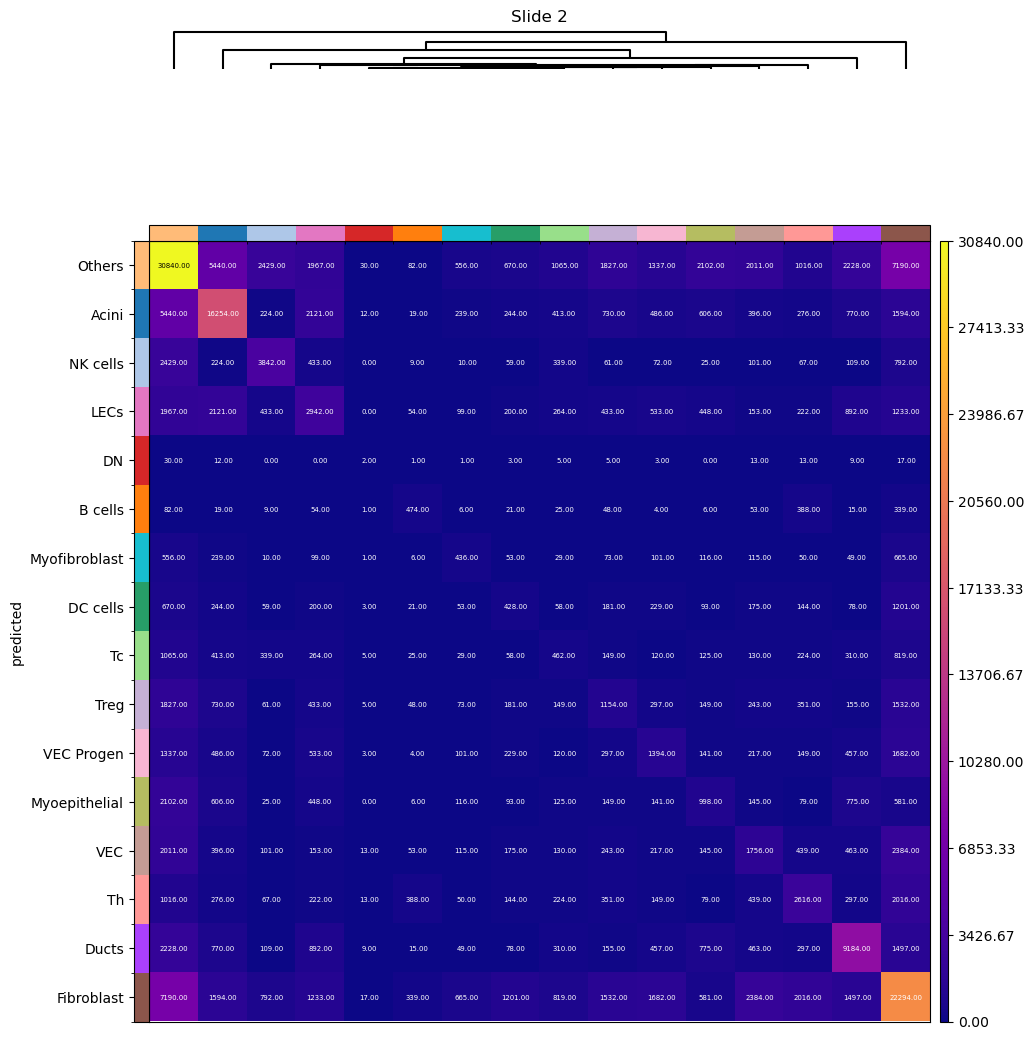

In [6]:
# test of color palettes

resDf = diseaseResFiles[0]

#extract infro from resfiles
resDf, coords, threshDf, tacitPredDf = preprocessRes(resDf)

print(tacitPredDf)

#add them to the adata
adata = AnnData(X = threshDf, obsm={"spatial": coords})
addTacitPred(adata, tacitPredDf)

#create neighborhood graph
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay = True, percentile=97.0)
#sc.pl.spatial(adata, color="predict_TACIT", neighbors_key = "spatial_neighbors", spot_size=10, edges=True, edges_color='black', title="Foci " + str(i))


#create the color map

cmap = matplotlib.cm.hot

cmap = matplotlib.cm.autumn
norm = Normalize(vmin=-20, vmax=10)
print(cmap(norm(5)))

#make interaction matrix, 
#set color use cmap, see https://matplotlib.org/stable/users/explain/colors/colormaps.html
sq.gr.interaction_matrix(adata, cluster_key="predicted")
sq.pl.interaction_matrix(adata, cluster_key="predicted", annotate=True, cmap='plasma', method="single", title="Slide " + str(i), size=5, save ="./a.png")



In [7]:
adata
# AnnData object with n_obs × n_vars = 420 × 14
#     obs: 'predict_TACIT'
#     uns: 'spatial_neighbors', 'predict_TACIT_interactions'
#     obsm: 'spatial'
#     obsp: 'spatial_connectivities', 'spatial_distances'

cellTypesLst = getCellTypes(adata)
print(cellTypesLst)

print(adata.obs)
#adata.uns
#adata.obsm
#print(adata.obsp["spatial_connectivities"])
#print(adata.obsp["spatial_distances"])

print(adata.uns)
print(adata.uns["predicted_interactions"])
print(np.amax(adata.uns["predicted_interactions"]))

['Acini', 'B cells', 'DC cells', 'DN', 'Ducts', 'Fibroblast', 'LECs', 'Myoepithelial', 'Myofibroblast', 'NK cells', 'Others', 'Tc', 'Th', 'Treg', 'VEC', 'VEC Progen']
        predicted
0          Others
1      Fibroblast
2           Acini
3              Th
4          Others
...           ...
38875         VEC
38876  Fibroblast
38877       Acini
38878  Fibroblast
38879      Others

[38880 rows x 1 columns]
OrderedDict([('spatial_neighbors', {'connectivities_key': 'spatial_connectivities', 'distances_key': 'spatial_distances', 'params': {'n_neighbors': 6, 'coord_type': 'generic', 'radius': None, 'transform': None}}), ('predicted_interactions', array([[1.6254e+04, 1.9000e+01, 2.4400e+02, 1.2000e+01, 7.7000e+02,
        1.5940e+03, 2.1210e+03, 6.0600e+02, 2.3900e+02, 2.2400e+02,
        5.4400e+03, 4.1300e+02, 2.7600e+02, 7.3000e+02, 3.9600e+02,
        4.8600e+02],
       [1.9000e+01, 4.7400e+02, 2.1000e+01, 1.0000e+00, 1.5000e+01,
        3.3900e+02, 5.4000e+01, 6.0000e+00, 6.0000e+00, 9

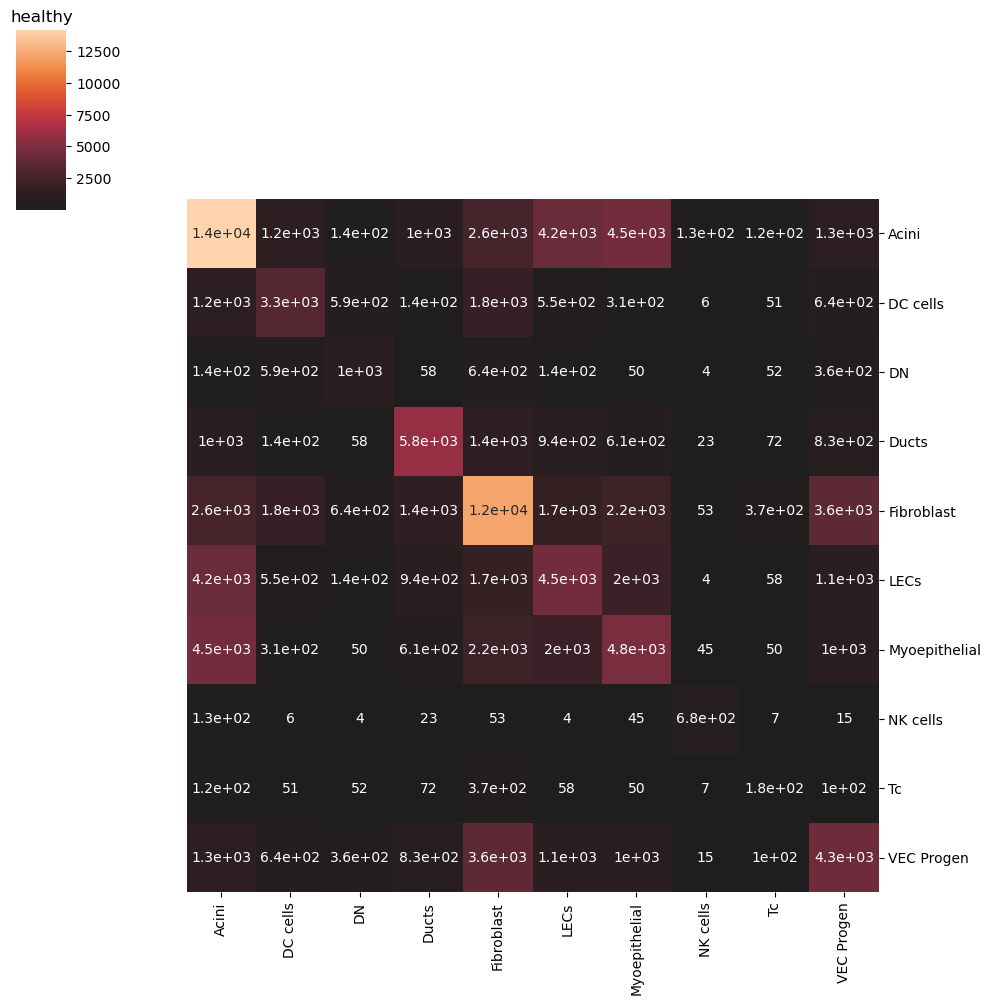

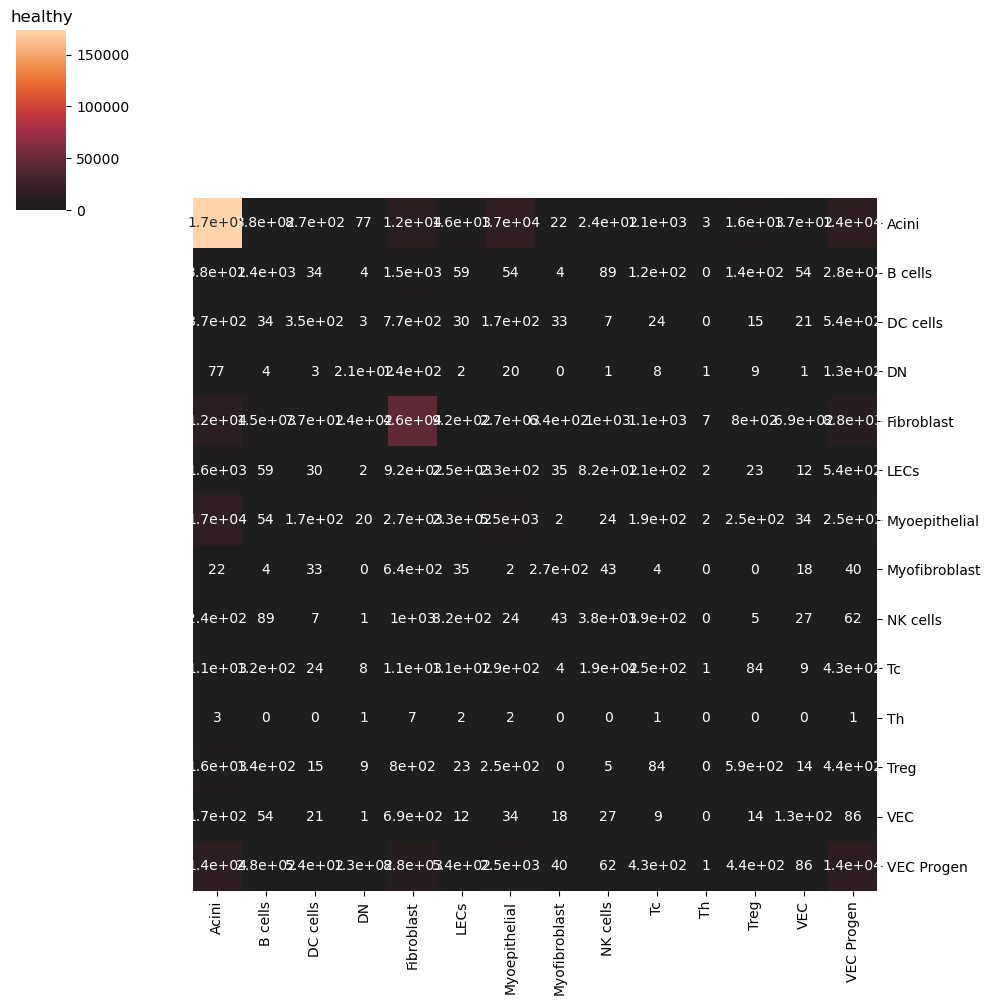

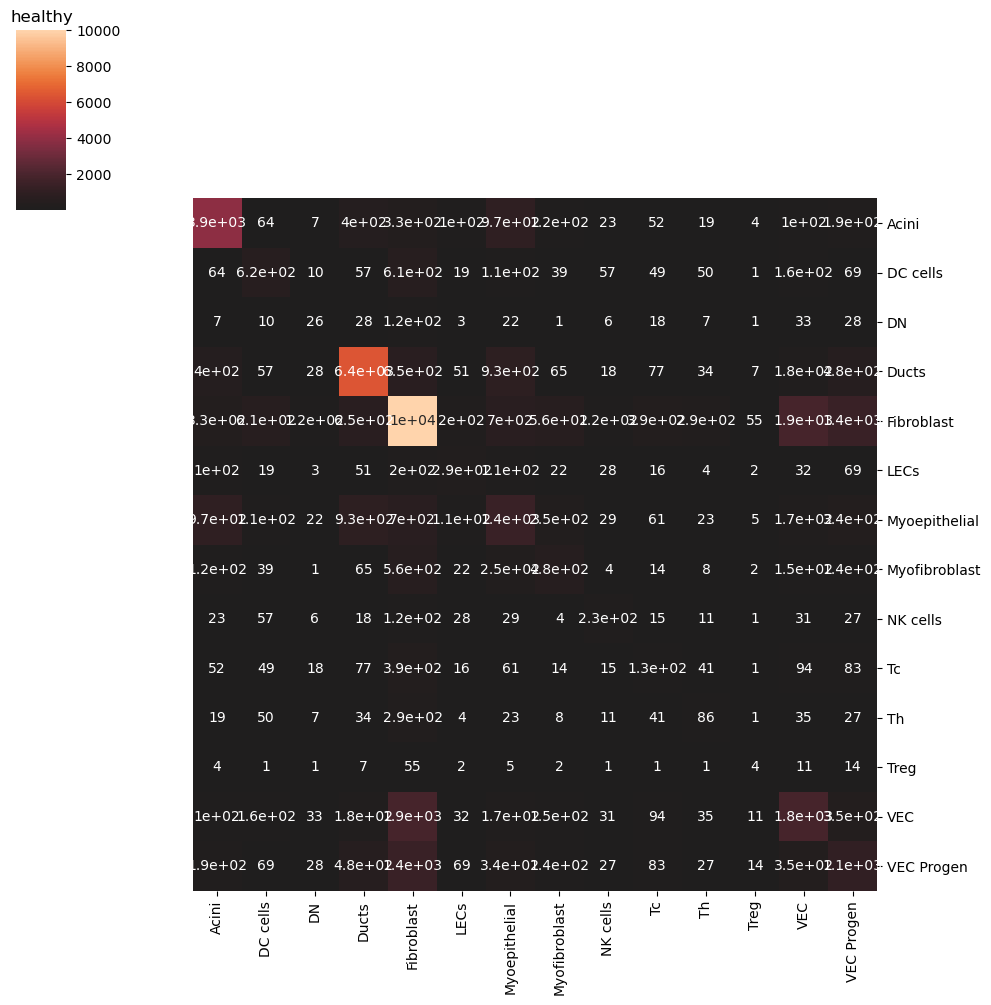

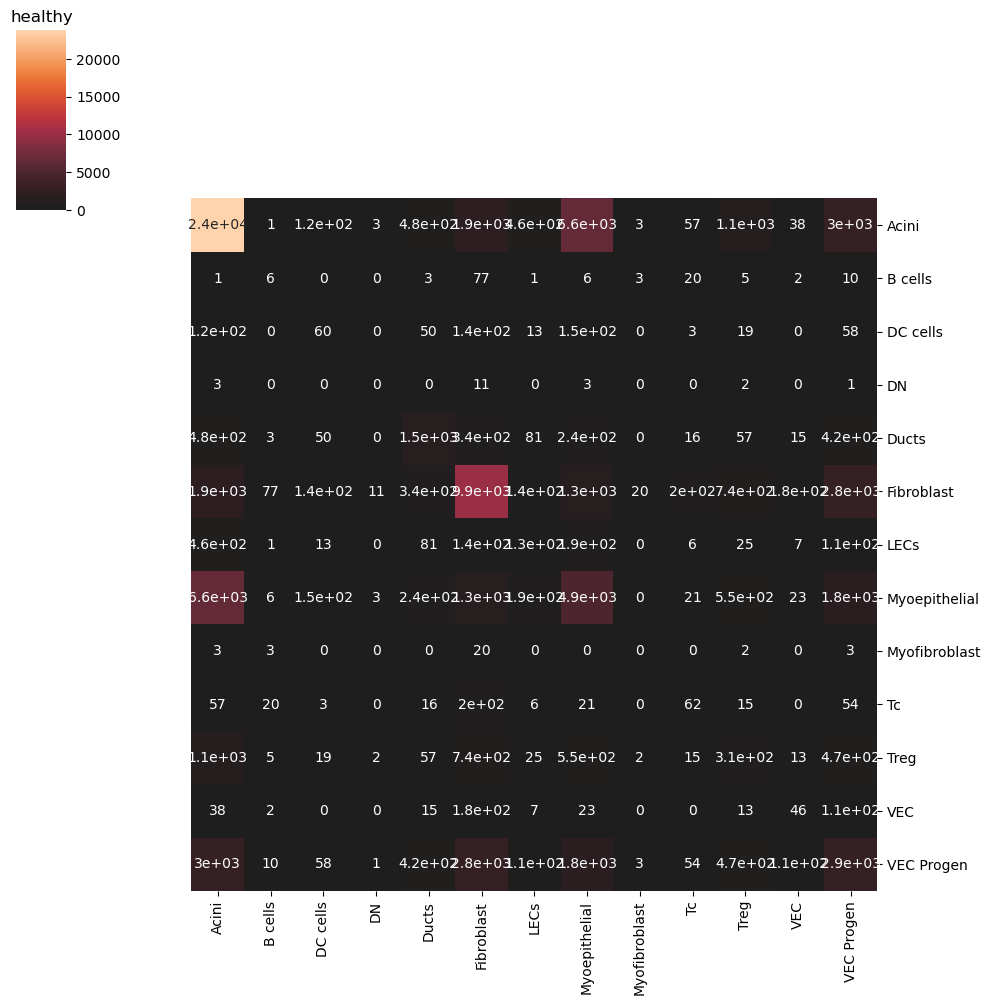

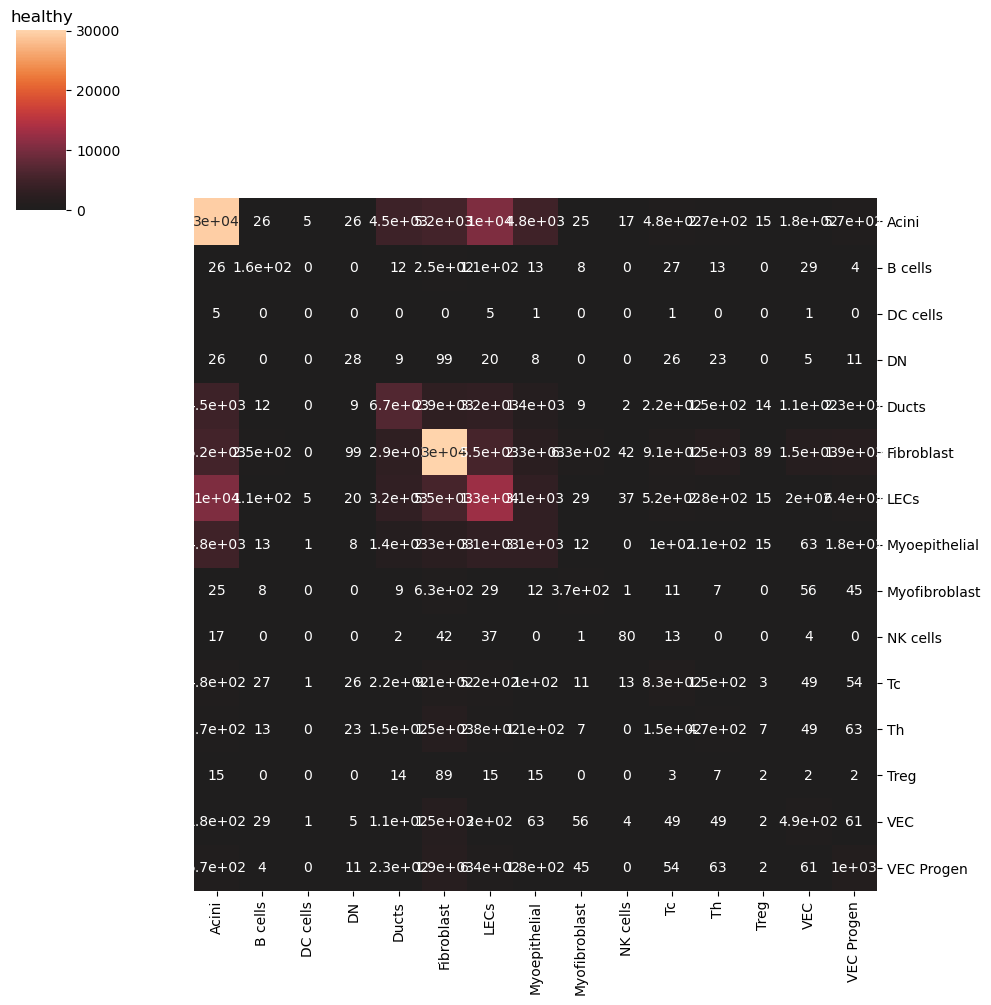

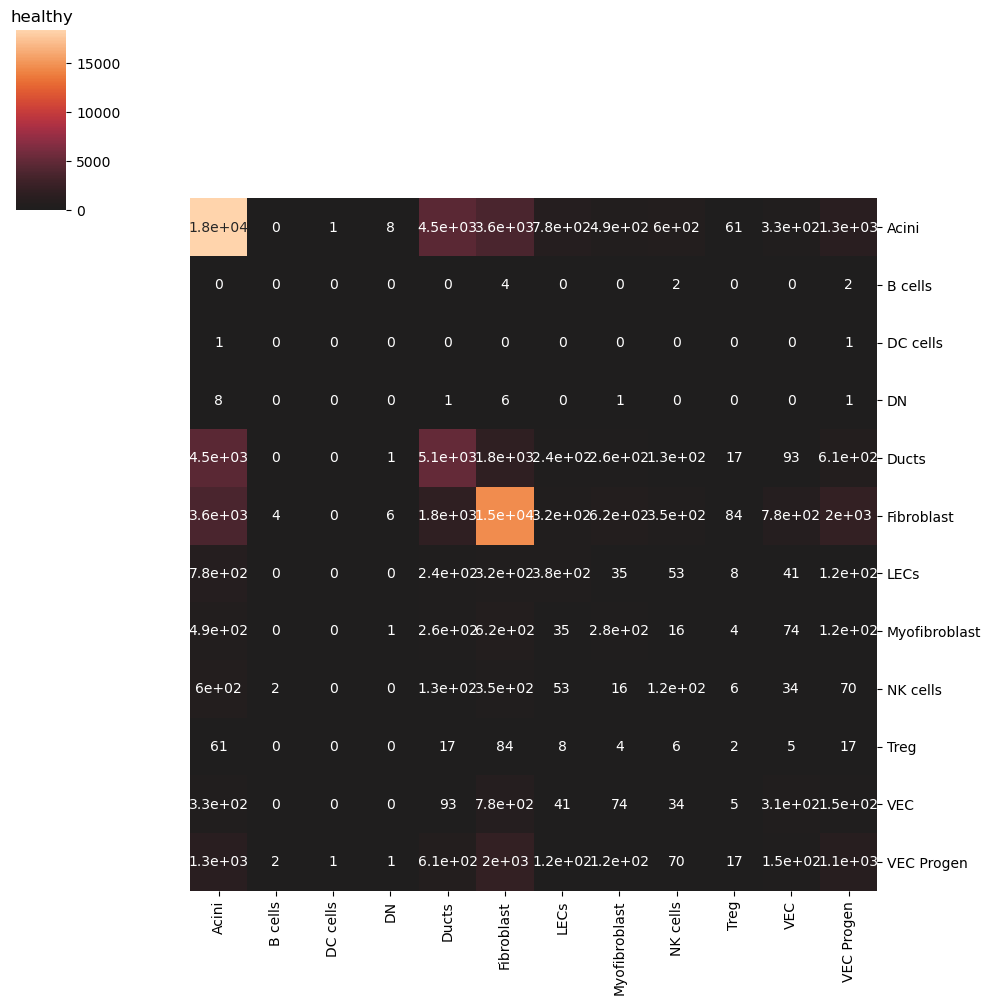

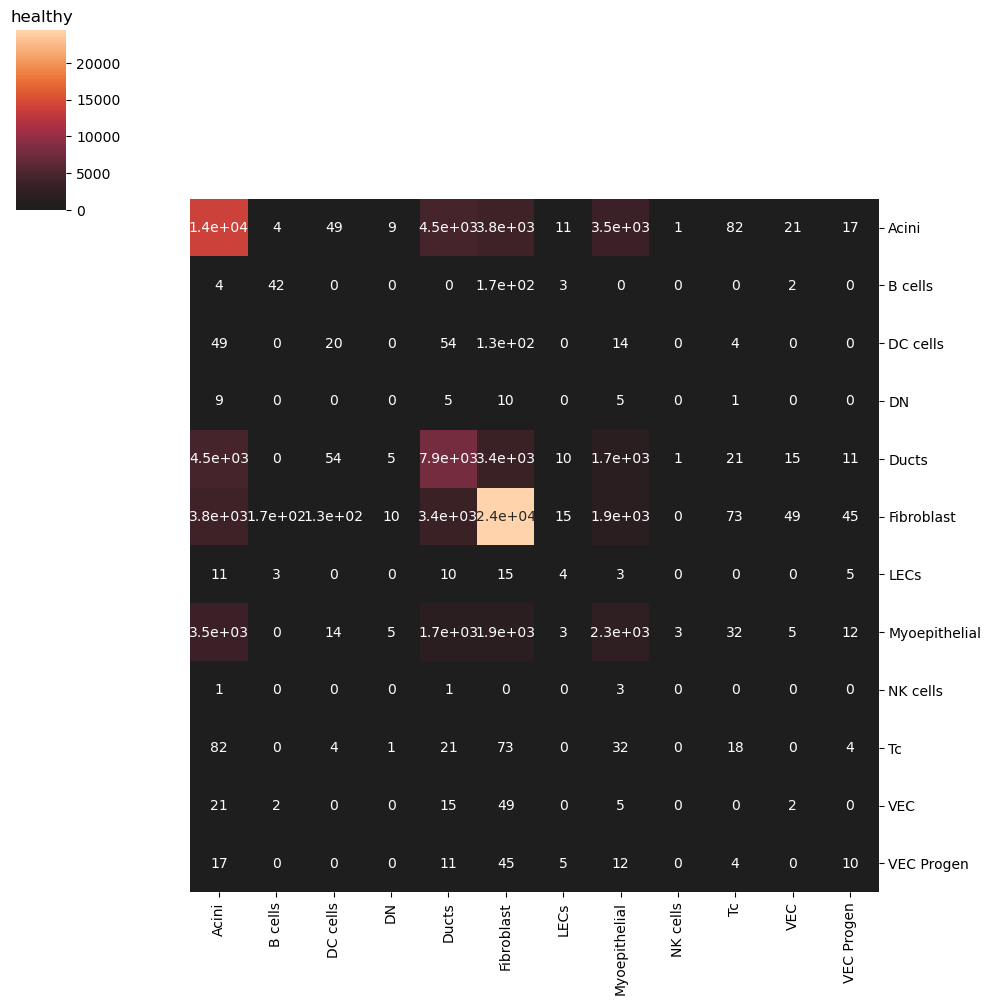

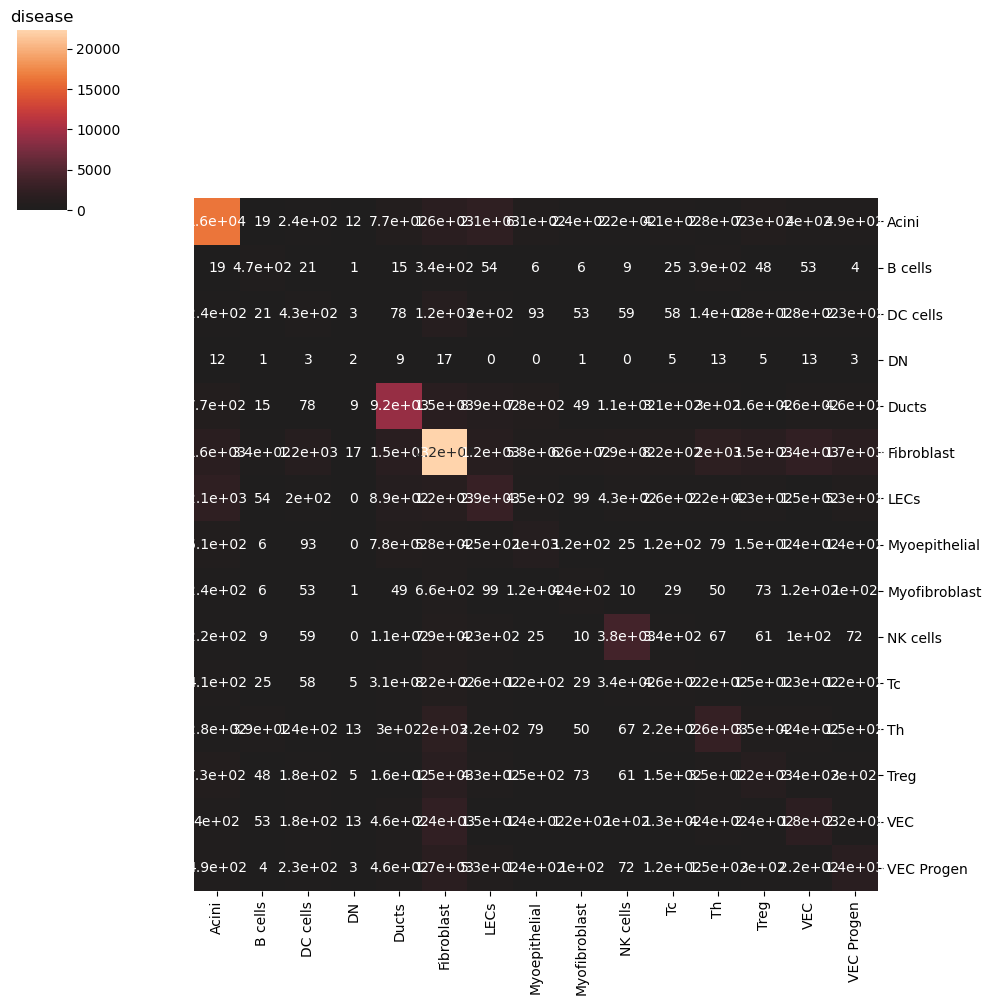

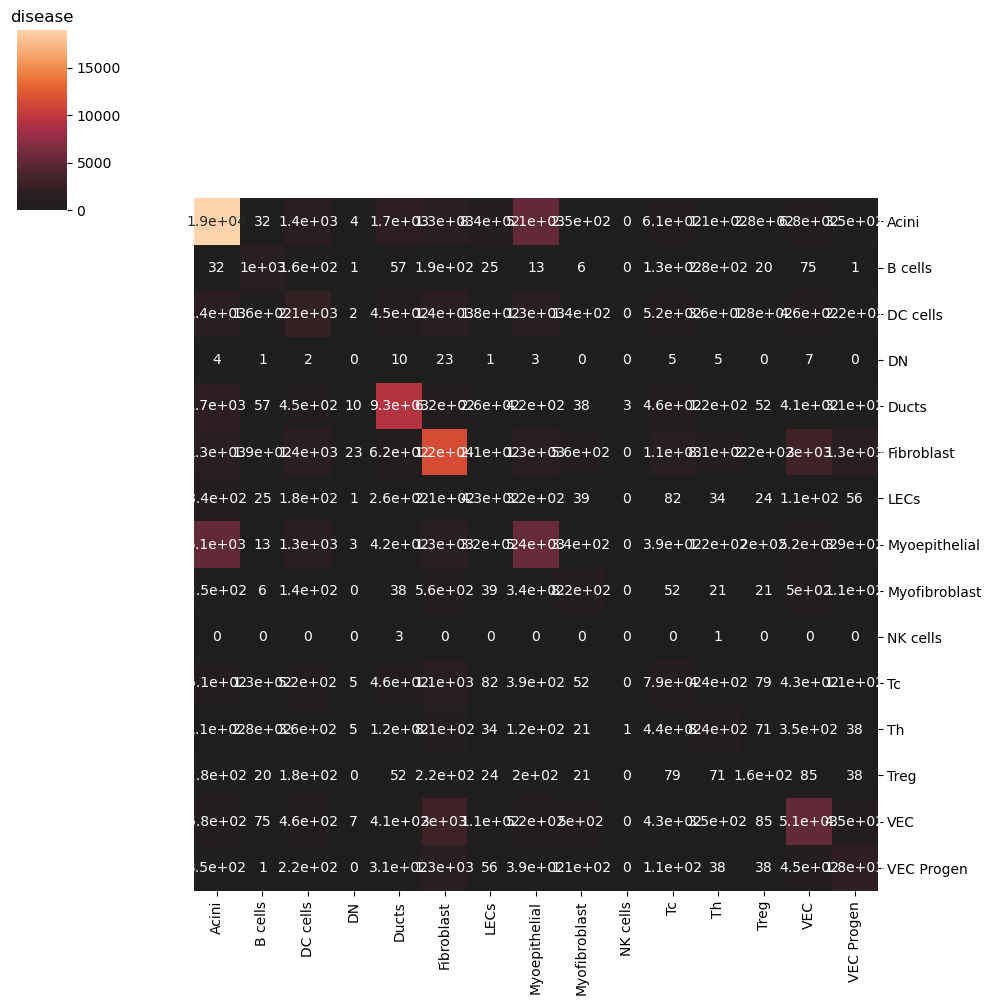

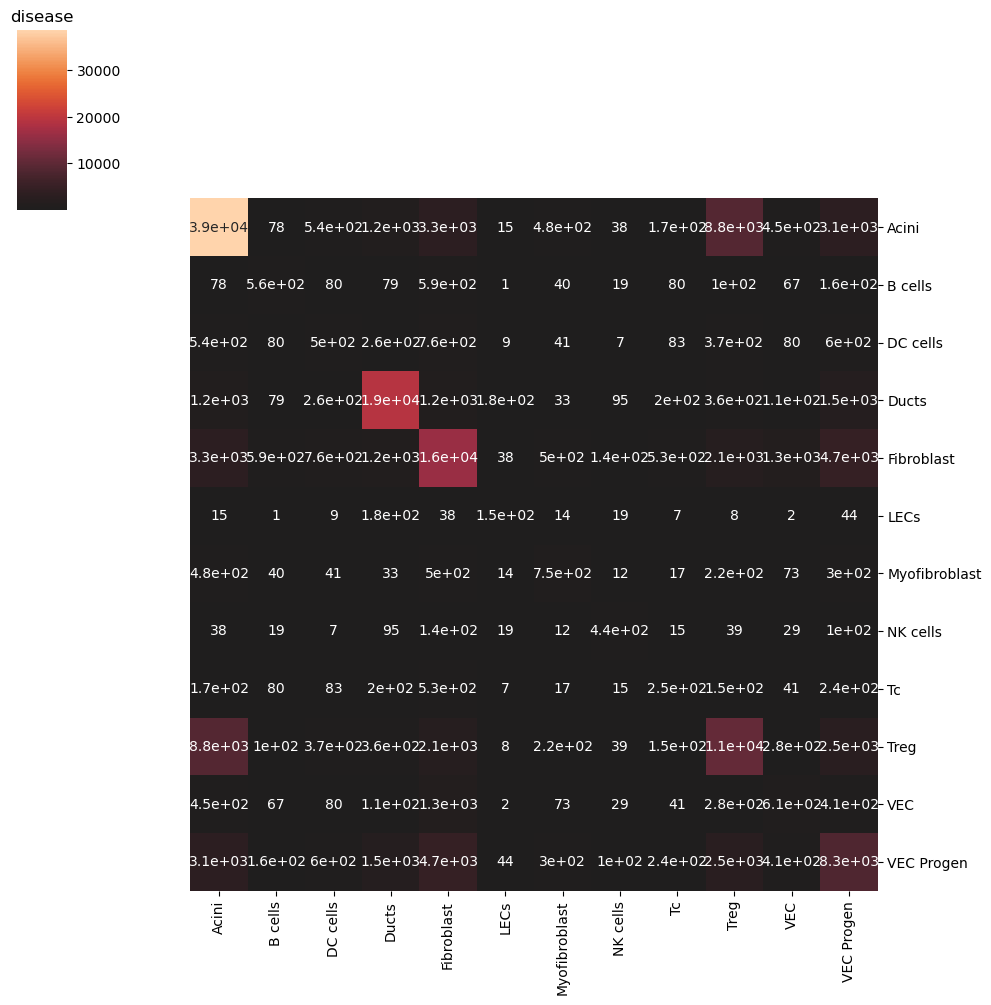

In [8]:
intMatsNoOther = dict()
intMatsNoOther["healthy"] = []
intMatsNoOther["disease"] = []
i=0
#remove other category
for cat in ["healthy", "disease"]:
  for adata in ads[cat]:
    #remove the 'Other' category
    intMatDf, cellTypesLst = removeOtherCat(adata)

    #visualize intmats
    intMatsNoOther[cat].append(intMatDf)
    sns.clustermap(intMatDf, row_cluster = False,col_cluster=False, method="single", metric='correlation', annot=True, center=0)
    plt.title(cat)# Save the interaction matrix as a CSV file
    intMatDf.to_csv(f'{"healthy"}_{i}.csv', index=False)
    i=i+1


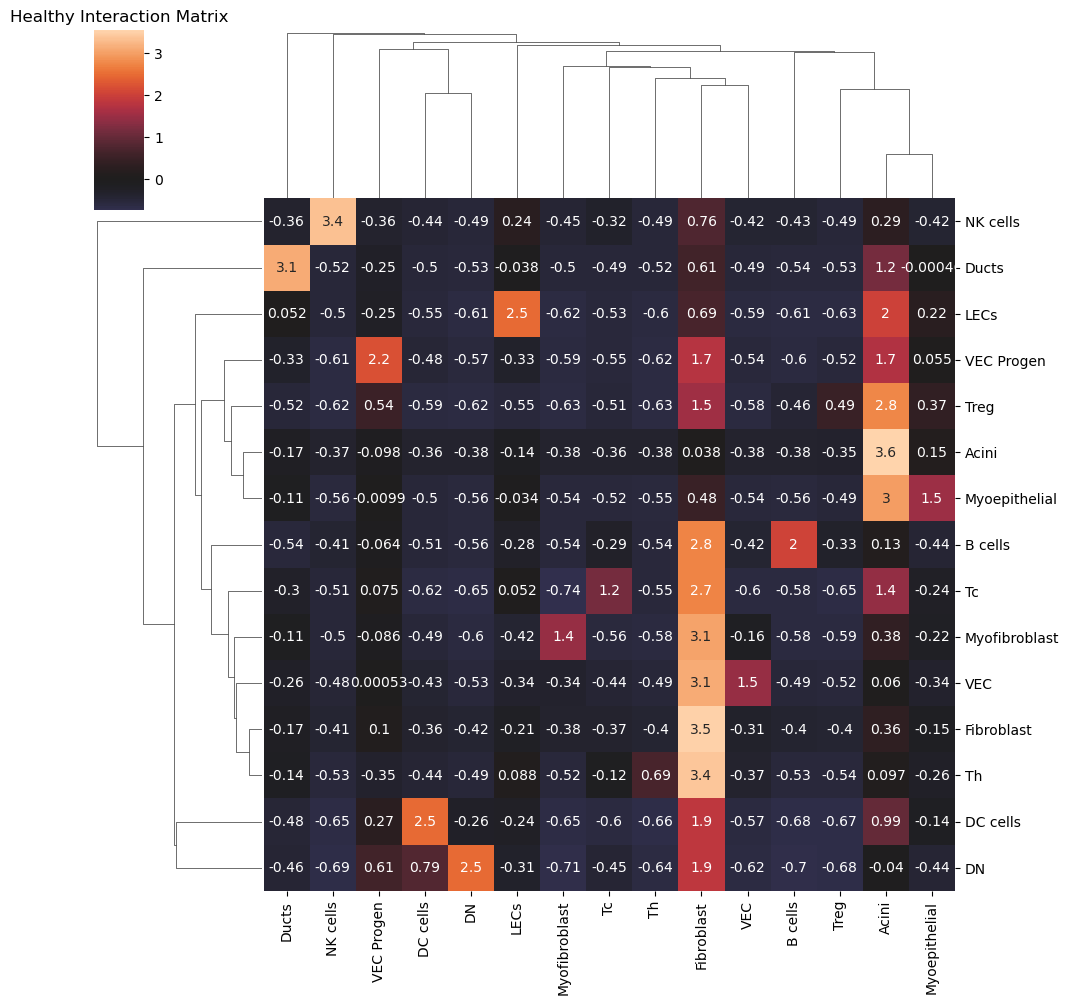

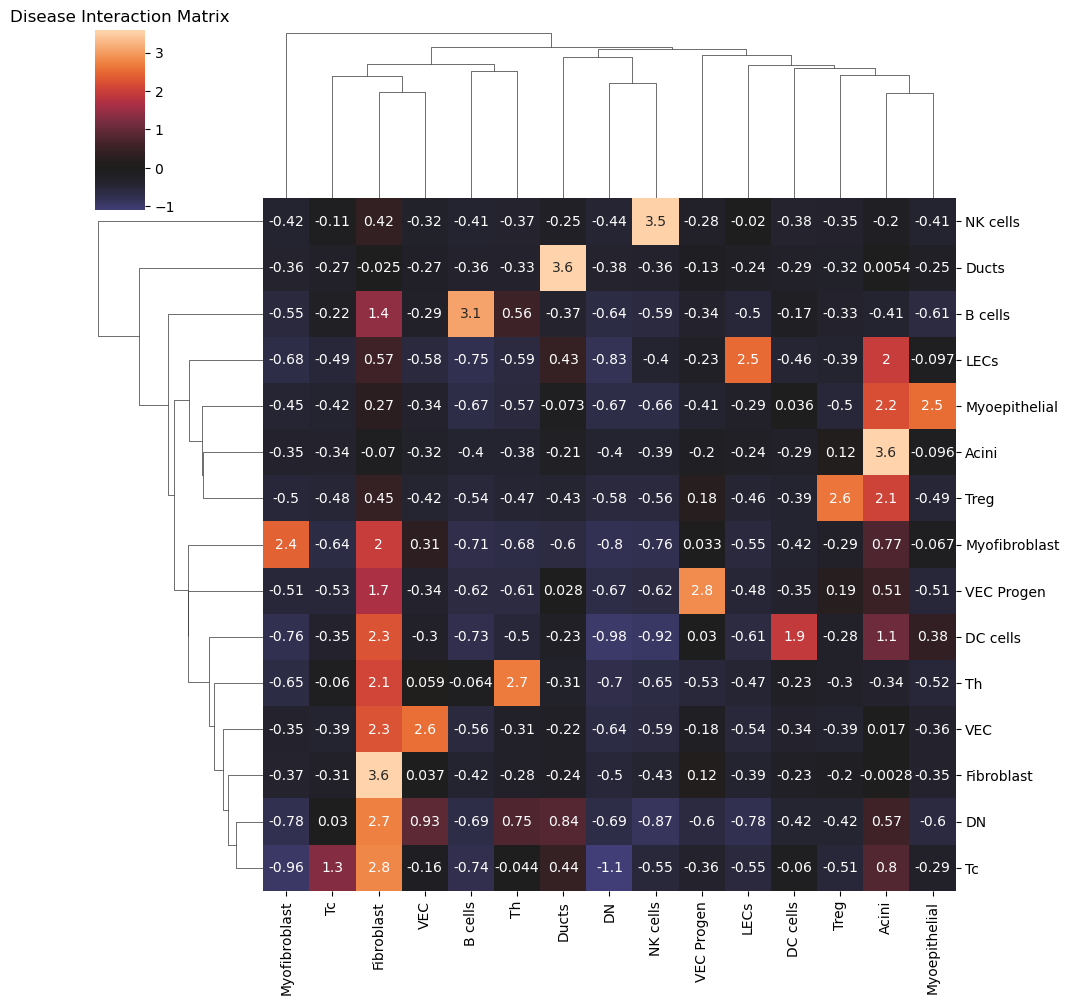

In [9]:
#combine all healthy intmats into avg (sum all, divide by 3)
healthyFinal = intMatsNoOther["healthy"][0]
for i in range(1, len(intMatsNoOther["healthy"])):
  healthyFinal = sumMatsByCat(healthyFinal, intMatsNoOther["healthy"][i])
healthyFinal = healthyFinal/len(intMatsNoOther["healthy"])
g = sns.clustermap(healthyFinal, row_cluster=True, col_cluster=True, method="single", metric='correlation', annot=True, z_score=0,center=0)
plt.title("Healthy Interaction Matrix")
g.savefig("/Users/khoahuynh/Downloads/Blake_SVG/healthy_interaction_matrix.svg")

#combine all disease intmats into avg
diseaseFinal = intMatsNoOther["disease"][0]
for i in range(1, len(intMatsNoOther["disease"])):
  diseaseFinal = sumMatsByCat(diseaseFinal, intMatsNoOther["disease"][i])
diseaseFinal = diseaseFinal/len(intMatsNoOther["disease"])

g2=sns.clustermap(diseaseFinal, row_cluster=True, col_cluster=True, method="single", metric='correlation', annot=True, z_score=0,center=0)
plt.title("Disease Interaction Matrix")
g2.savefig("/Users/khoahuynh/Downloads/Blake_SVG/disease_interaction_matrix.svg")


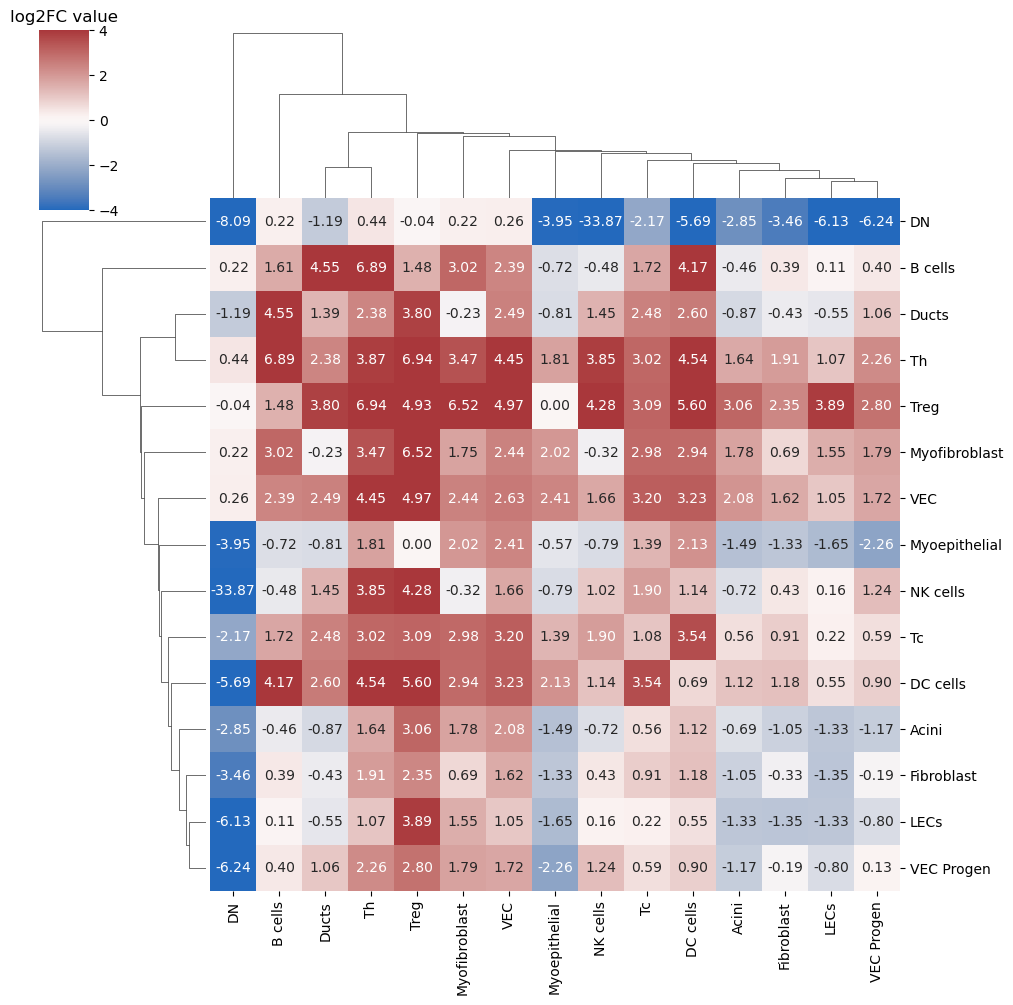

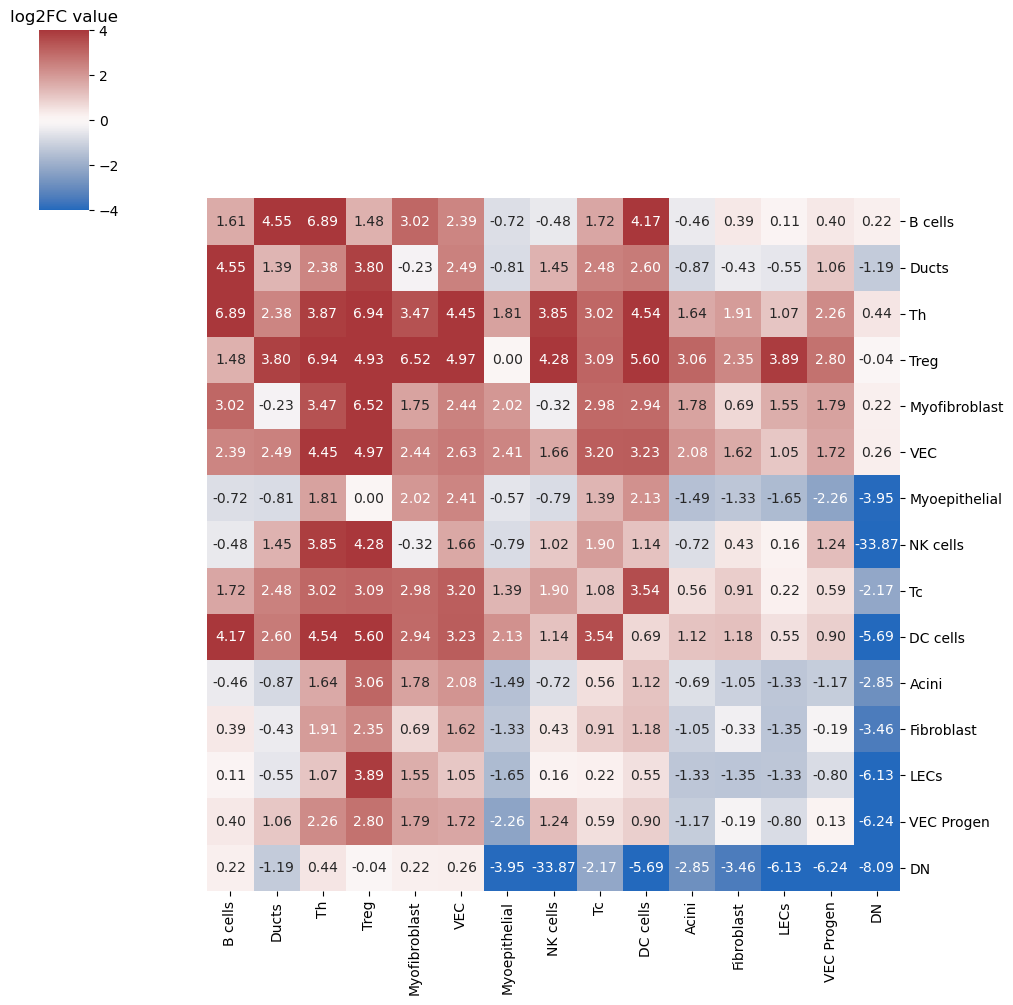

In [38]:
#subtraction matrix between healthy and diseased, use seismic cmap

# To prevent division by zero or log of zero, add a small value (e.g., 1e-10)
log2FC = np.log2((diseaseFinal + 1e-10) / (healthyFinal + 1e-10))

cmap = sns.color_palette("vlag", as_cmap=True)
avgSubIntMatPlot = sns.clustermap(log2FC, row_cluster=True, col_cluster=True, method="single", 
                                  metric='correlation', annot=True, fmt=".2f", 
                                  center=0, cmap=cmap,vmin=-4, vmax=4)
plt.title("log2FC value")
#fig, ax = plt.subplots(figsize=(15, 12))
#avgSubIntMatPlot.savefig("/Users/khoahuynh/Downloads/Blake_SVG/diff_interaction_matrix.svg", bbox_inches='tight')


cols_order = ['B cells', 'Ducts', 'Th',"Treg","Myofibroblast","VEC","Myoepithelial","NK cells","Tc","DC cells","Acini","Fibroblast" , 'LECs', 'VEC Progen', 'DN']
log2FC = log2FC.loc[cols_order, cols_order]


cg = sns.clustermap(log2FC, row_cluster=False, col_cluster=False, method="single", 
                    metric='correlation', annot=True, fmt=".2f", 
                    center=0, cmap=cmap, figsize=(10, 10),vmin=-4, vmax=4)
plt.title("log2FC value")
cg.savefig("/Users/khoahuynh/Downloads/Blake_image_2/diff_interaction_matrix.svg", bbox_inches='tight')






In [ ]:
print(diseaseFinal)